
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_119457/1883313200.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


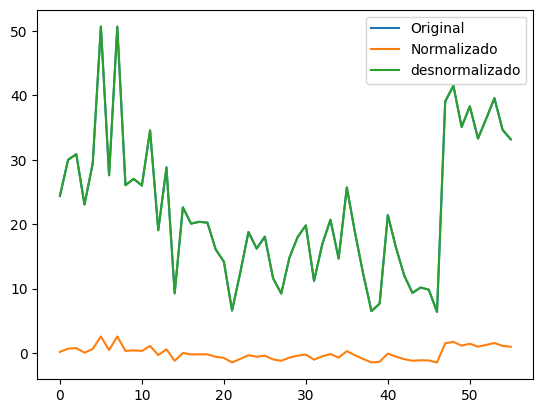

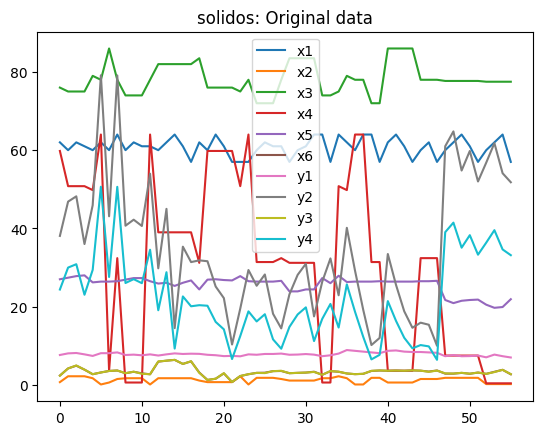

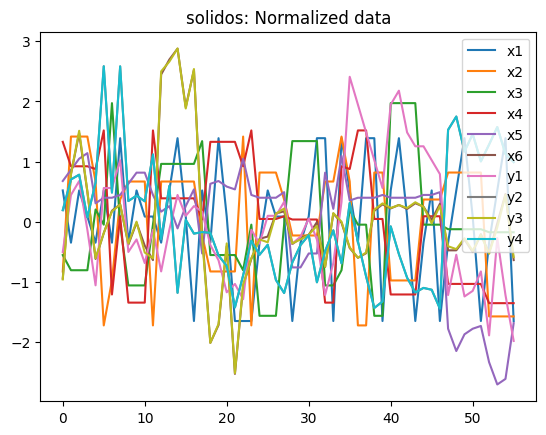

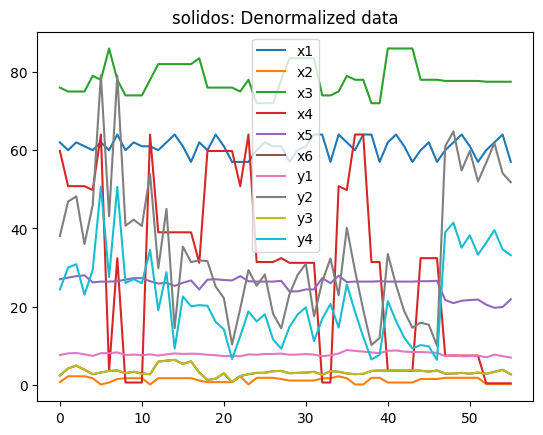

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-26 20:01:46.321961: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 20:01:46.381046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 20:01:46.381092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 20:01:46.382601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 20:01:46.393878: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 20:01:46.394874: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.1909456200000932
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.3741590409999844
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.36303019400020275
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.3584547830005249
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.3881120699998064
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.361057618999439
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 7 +++++++++++++

2024-05-26 20:02:27.484778: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_2] | 9 ++++++++++++++++++
Elapsed time:  0.3230408389999866
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_2] | 10 ++++++++++++++++++
Elapsed time:  0.3433540189998894
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_2] | 11 ++++++++++++++++++
Elapsed time:  0.33024452600056975
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_2] | 12 ++++++++++++++++++
Elapsed time:  0.3201755769996453
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_2] | 13 ++++++++++++++++++
Elapsed time:  0.41427430899966566
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_2] | 14 ++++++++++++++++++
Elapsed time:  0.3149505069995939
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_2] | 15 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_3_0,0.800664,0.778318,0.633982,0.700059,24.039994,25.377120,63.462707,43.299761
model_1_3_8,0.802556,0.564384,0.444457,0.503126,23.811822,49.867142,96.323903,71.729153
model_1_3_7,0.805948,0.588514,0.462338,0.523363,23.402732,47.104902,93.223545,68.807789
model_1_3_1,0.807498,0.753786,0.602968,0.672231,23.215759,28.185378,68.840213,47.317072
model_1_3_6,0.808903,0.614139,0.481489,0.544945,23.046400,44.171500,89.902917,65.692179
model_1_3_2,0.811165,0.726339,0.574022,0.644348,22.773519,31.327343,73.858993,51.342241
model_1_3_5,0.811196,0.641072,0.501999,0.567844,22.769868,41.088358,86.346805,62.386457
model_1_3_4,0.812557,0.669046,0.524024,0.592036,22.605735,37.886026,82.528071,58.894058
model_1_3_3,0.812670,0.697678,0.547859,0.617529,22.592019,34.608295,78.395253,55.213923


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.3475624359998619
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.3346499130002485
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.3967437559995233
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.4104451479997806
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.341565561000607
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.30753445600021223
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.355737504999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_4_0,0.813573,0.974335,0.982160,0.978000,22.483184,3.990589,2.313453,3.201346
model_1_4_1,0.845233,0.973518,0.966995,0.971179,18.664998,4.117617,4.279990,4.194027
model_1_4_2,0.868542,0.971898,0.941467,0.959557,15.853850,4.369484,7.590367,5.885195
model_1_4_24,0.882400,0.924117,0.344118,0.682025,14.182589,11.798724,85.052545,46.271106
model_1_4_23,0.884034,0.925114,0.355130,0.687206,13.985575,11.643750,83.624498,45.517056
model_1_4_3,0.885352,0.969703,0.908922,0.944667,13.826632,4.710794,11.810713,8.051934
model_1_4_22,0.885798,0.926208,0.367266,0.692915,13.772792,11.473712,82.050716,44.686422
model_1_4_21,0.887696,0.927406,0.380630,0.699196,13.543892,11.287373,80.317792,43.772283
model_1_4_20,0.889728,0.928717,0.395327,0.706102,13.298859,11.083496,78.411907,42.767457
model_1_4_19,0.891890,0.930149,0.411471,0.713682,13.038085,10.860909,76.318390,41.664428


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.5879517490002399
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.30713582200041856
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.30181733700010227
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.24033751799925085
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.34763610400023026
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.30119356800059904
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.3265143

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_24,0.880928,0.623860,0.788940,0.675224,14.360145,72.171412,19.284467,47.283441
model_1_5_23,0.881118,0.624451,0.789417,0.675777,14.337166,72.058122,19.240881,47.202919
model_1_5_22,0.881327,0.625104,0.789943,0.676388,14.311963,71.932724,19.192817,47.113944
model_1_5_21,0.881556,0.625827,0.790522,0.677063,14.284368,71.794139,19.139926,47.015689
model_1_5_20,0.881806,0.626625,0.791159,0.677808,14.254181,71.640936,19.081727,46.907172
model_1_5_19,0.882080,0.627508,0.791859,0.678631,14.221230,71.471596,19.017747,46.787422
model_1_5_18,0.882377,0.628481,0.792627,0.679537,14.185372,71.284764,18.947574,46.655468
model_1_5_17,0.882700,0.629556,0.793468,0.680535,14.146463,71.078585,18.870742,46.510218
model_1_5_16,0.883049,0.630740,0.794388,0.681632,14.104350,70.851459,18.786674,46.350406
model_1_5_15,0.883425,0.632043,0.795391,0.682838,14.058970,70.601403,18.694988,46.174886


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.5405204879998564
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.38420118799967895
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.32212834199981444
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.38272627200058196
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.29155850099959935
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.2473747550002372
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.39180703

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.925446,0.845548,0.910706,0.864140,8.991196,11.197454,2.299004,7.009951
model_1_6_1,0.933635,0.818874,0.909379,0.843987,8.003672,13.131229,2.333180,8.049789
model_1_6_24,0.935262,0.438917,0.666640,0.504349,7.807370,40.677398,8.582874,25.574096
model_1_6_23,0.935910,0.445008,0.671357,0.509988,7.729315,40.235753,8.461436,25.283134
model_1_6_22,0.936611,0.451715,0.676548,0.516196,7.644763,39.749546,8.327784,24.962841
model_1_6_21,0.937367,0.459089,0.682252,0.523021,7.553515,39.214908,8.180929,24.610692
model_1_6_20,0.938181,0.467190,0.688510,0.530517,7.455432,38.627634,8.019794,24.223945
model_1_6_19,0.939050,0.476074,0.695369,0.538736,7.350545,37.983537,7.843214,23.799860
model_1_6_2,0.939583,0.791883,0.902730,0.822348,7.286330,15.088041,2.504365,9.166306
model_1_6_18,0.939975,0.485807,0.702870,0.547737,7.238995,37.277939,7.650077,23.335409


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.32366755700059
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.277352410000276
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.3211905670004853
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.33560964500065893
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.2858655420004652
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.301448500999868
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.311919425999803

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_0,0.945021,0.875173,0.951621,0.917338,6.630499,6.543836,3.447265,5.086625
model_1_7_1,0.952634,0.867294,0.953350,0.914727,5.712302,6.956872,3.324039,5.247305
model_1_7_2,0.958531,0.858539,0.953586,0.910907,5.001115,7.415833,3.307218,5.482367
model_1_7_3,0.963056,0.849237,0.952651,0.906202,4.455476,7.903496,3.373835,5.771890
model_1_7_4,0.966485,0.839648,0.950809,0.900874,4.041958,8.406164,3.505123,6.099793
model_1_7_5,0.969041,0.829978,0.948274,0.895131,3.733636,8.913070,3.685722,6.453142
model_1_7_24,0.970561,0.714062,0.891079,0.811684,3.550333,14.989782,7.761230,11.588109
model_1_7_23,0.970833,0.716797,0.892790,0.813850,3.517492,14.846399,7.639273,11.454811
model_1_7_6,0.970906,0.820389,0.945230,0.889148,3.508722,9.415771,3.902658,6.821367
model_1_7_22,0.971123,0.719802,0.894656,0.816222,3.482597,14.688895,7.506315,11.308865


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.43917477000013605
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.3202522470000986
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.3986158030002116
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.3531671609998739
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.33845474400004605
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.23641966299965134
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.341039070

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_0,0.976917,0.885484,0.952763,0.913772,2.783830,11.048412,3.641053,7.562604
model_1_8_1,0.977761,0.886096,0.952726,0.914114,2.682057,10.989309,3.643908,7.532652
model_1_8_2,0.978417,0.886595,0.952396,0.914268,2.602877,10.941208,3.669344,7.519149
model_1_8_3,0.978924,0.887003,0.951851,0.914280,2.541738,10.901865,3.711372,7.518108
model_1_8_4,0.979312,0.887336,0.951152,0.914185,2.494979,10.869678,3.765208,7.526397
model_1_8_5,0.979605,0.887611,0.950351,0.914014,2.459632,10.843197,3.826994,7.541456
model_1_8_6,0.979823,0.887837,0.949486,0.913787,2.433320,10.821407,3.893669,7.561297
model_1_8_7,0.979983,0.888024,0.948588,0.913525,2.414107,10.803357,3.962880,7.584307
model_1_8_24,0.980037,0.888949,0.938014,0.909690,2.407581,10.714098,4.777934,7.920611
model_1_8_23,0.980058,0.888937,0.938327,0.909813,2.405047,10.715243,4.753796,7.909860


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.3388173020002796
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.30679329500071617
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.2897512949994052
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.33953372100040724
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.35051516800012905
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.3491095069994117
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.370812964

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_24,0.978798,0.989184,0.814454,0.908616,2.556990,1.009832,16.695060,8.391117
model_1_9_23,0.979027,0.989378,0.816557,0.909690,2.529327,0.991727,16.505892,8.292509
model_1_9_22,0.979278,0.989591,0.818877,0.910875,2.499106,0.971834,16.297092,8.183717
model_1_9_21,0.979551,0.989825,0.821437,0.912181,2.466167,0.950013,16.066818,8.063801
model_1_9_20,0.979848,0.990081,0.824256,0.913619,2.430368,0.926127,15.813153,7.931787
model_1_9_19,0.980169,0.990360,0.827359,0.915200,2.391566,0.900015,15.533967,7.786580
model_1_9_18,0.980517,0.990665,0.830769,0.916937,2.349672,0.871537,15.227120,7.627105
model_1_9_17,0.980890,0.990998,0.834512,0.918842,2.304618,0.840532,14.890292,7.452184
model_1_9_16,0.981290,0.991358,0.838614,0.920927,2.256419,0.806885,14.521217,7.260689
model_1_9_15,0.981715,0.991748,0.843100,0.923206,2.205169,0.770474,14.117577,7.051462


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.6657431349995022
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.3608801240006869
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.3293591940000624
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.3228939979999268
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.38291868699980114
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.3027160390001882
Stopped at epoch:  6
1/1 [==============================] - 0s 23m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_2_0,0.801875,0.516042,0.531133,0.533951,23.893989,68.917901,52.254702,61.076394
model_2_2_1,0.810293,0.518133,0.528156,0.533962,22.878714,68.620185,52.586495,61.074922
model_2_2_2,0.816855,0.519220,0.524709,0.533208,22.087296,68.465365,52.970683,61.173755
model_2_2_3,0.821938,0.519500,0.521022,0.531894,21.474319,68.425539,53.381547,61.346007
model_2_2_4,0.825840,0.519114,0.517274,0.530172,21.003752,68.480405,53.799311,61.571654
model_2_2_5,0.828798,0.518167,0.513595,0.528155,20.647023,68.615271,54.209329,61.835995
model_2_2_6,0.831002,0.516749,0.510077,0.525931,20.381161,68.817204,54.601400,62.127415
model_2_2_7,0.832610,0.514954,0.506786,0.523581,20.187259,69.072882,54.968200,62.435389
model_2_2_8,0.833747,0.512868,0.503752,0.521167,20.050166,69.369987,55.306271,62.751772
model_2_2_19,0.834142,0.489652,0.483516,0.499713,20.002491,72.676009,57.561608,65.563336


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Elapsed time:  0.292337404999671
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Elapsed time:  0.3363693459996284
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Elapsed time:  0.38795737700002064
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Elapsed time:  0.350460824000038
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Elapsed time:  0.34558963400013454
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Elapsed time:  0.3157471759996042
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Elapsed time:  0.291375998999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_3_24,0.825242,0.769930,-0.129703,0.509426,21.075866,42.665628,98.997747,69.174859
model_2_3_23,0.829170,0.775818,-0.104446,0.520912,20.602174,41.573679,96.784489,67.555235
model_2_3_22,0.833438,0.782310,-0.077013,0.533455,20.087486,40.369831,94.380446,65.786587
model_2_3_21,0.838054,0.789445,-0.047329,0.547104,19.530700,39.046682,91.779161,63.861962
model_2_3_20,0.843023,0.797259,-0.015350,0.561897,18.931459,37.597638,88.976832,61.776080
model_2_3_19,0.848336,0.805775,0.018912,0.577847,18.290741,36.018333,85.974397,59.527069
model_2_3_18,0.853972,0.815002,0.055396,0.594941,17.610961,34.307113,82.777191,57.116560
model_2_3_17,0.859895,0.824925,0.093968,0.613130,16.896682,32.467041,79.397092,54.551776
model_2_3_16,0.866045,0.835493,0.134404,0.632314,16.155071,30.507199,75.853596,51.846680
model_2_3_15,0.872341,0.846623,0.176430,0.652354,15.395731,28.443230,72.170816,49.020916


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  0.3254644910002753
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.30673641599969415
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.2929699950000213
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.3867495959993903
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.3575587159994029
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.3593932149997272
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.30872879199

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_4_7,0.808971,-0.607946,0.794369,0.343240,23.038118,104.644075,27.799633,68.481977
model_2_4_6,0.823275,-0.459731,0.831474,0.414853,21.313113,94.998317,22.783309,61.014797
model_2_4_5,0.838838,-0.293663,0.873852,0.495581,19.436144,84.190774,17.054208,52.597068
model_2_4_0,0.854131,0.453144,0.990974,0.813801,17.591877,35.589026,1.220198,19.415468
model_2_4_4,0.854505,-0.110597,0.916826,0.582289,17.546766,72.276911,11.244450,43.555729
model_2_4_3,0.866595,0.076738,0.948866,0.663737,16.088712,60.085288,6.912928,35.063011
model_2_4_1,0.867401,0.378235,0.982723,0.784015,15.991532,40.464035,2.335696,22.521288
model_2_4_2,0.871243,0.242060,0.968541,0.730367,15.528173,49.326226,4.253029,28.115310


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.37147763000029954
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.3635367069991844
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.333309053999983
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.3096038989997396
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.300881720999314
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.3008670090002852
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.3018345880000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_0,0.814298,0.967761,0.126696,0.691119,22.395751,2.612910,62.589407,30.837145
model_2_5_1,0.834072,0.953023,0.136823,0.688206,20.011001,3.807382,61.863620,31.127979
model_2_5_2,0.849340,0.935933,0.142736,0.682858,18.169680,5.192486,61.439867,31.661839
model_2_5_3,0.861028,0.917269,0.145623,0.675813,16.760034,6.705127,61.232912,32.365256
model_2_5_4,0.869882,0.897697,0.146348,0.667646,15.692223,8.291353,61.180980,33.180573
model_2_5_5,0.876499,0.877765,0.145542,0.658807,14.894233,9.906790,61.238773,34.063043
model_2_5_6,0.881357,0.857908,0.143658,0.649636,14.308382,11.516180,61.373800,34.978591
model_2_5_24,0.883741,0.644283,0.091260,0.540123,14.020929,28.829929,65.129124,45.911889
model_2_5_23,0.884294,0.649520,0.093024,0.542969,13.954207,28.405470,65.002666,45.627684
model_2_5_7,0.884838,0.838459,0.141034,0.640391,13.888565,13.092477,61.561802,35.901572


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.7985206720004498
Stopped at epoch:  14
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.333261262000633
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.32355373700011114
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.34979919199940923
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.37404515399975935
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.3791022349996638
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.270936696

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.969682,0.940398,0.866259,0.935264,3.656383,2.904555,9.917813,6.204912
model_2_6_1,0.972247,0.933021,0.869078,0.934305,3.347019,3.264042,9.708724,6.296833
model_2_6_2,0.974253,0.925872,0.871425,0.933235,3.105093,3.612466,9.534677,6.399388
model_2_6_3,0.975812,0.919019,0.873375,0.932101,2.917024,3.946425,9.390115,6.508158
model_2_6_4,0.977016,0.912512,0.874991,0.930938,2.771844,4.263513,9.270228,6.619614
model_2_6_5,0.977938,0.906381,0.876330,0.929775,2.660725,4.562299,9.170942,6.731071
model_2_6_6,0.978636,0.900640,0.877439,0.928633,2.576561,4.842064,9.088741,6.840493
model_2_6_7,0.979157,0.895294,0.878355,0.927528,2.513669,5.102588,9.020766,6.946436
model_2_6_8,0.979540,0.890338,0.879114,0.926470,2.467472,5.344112,8.964519,7.047828
model_2_6_9,0.979815,0.885760,0.879742,0.925467,2.434334,5.567194,8.917977,7.144032


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.3132344350005951
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.2809511549994568
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.34596690200032754
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.33126576599988766
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.332460120000178
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.2956631279994326
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.35044790499

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_0,0.982480,0.952739,0.996751,0.977879,2.112930,4.727017,0.456640,2.717426
model_2_7_1,0.984448,0.952440,0.996616,0.977678,1.875571,4.756915,0.475503,2.742133
model_2_7_24,0.985719,0.923584,0.975801,0.954034,1.722339,7.643062,3.400548,5.646585
model_2_7_23,0.985855,0.924212,0.976214,0.954527,1.705895,7.580299,3.342599,5.586083
model_2_7_2,0.985893,0.951661,0.996043,0.977033,1.701334,4.834876,0.556061,2.821316
model_2_7_22,0.986002,0.924899,0.976667,0.955067,1.688125,7.511591,3.278891,5.519730
model_2_7_21,0.986161,0.925649,0.977165,0.955659,1.669000,7.436522,3.208958,5.447077
model_2_7_20,0.986331,0.926468,0.977710,0.956305,1.648506,7.354631,3.132301,5.367652
model_2_7_19,0.986512,0.927359,0.978307,0.957011,1.626663,7.265485,3.048427,5.280985
model_2_7_18,0.986704,0.928327,0.978959,0.957779,1.603531,7.168694,2.956799,5.186627


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.29480446000070515
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.30341226600012305
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.30655857600049785
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.34898672300005273
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.30288537999967957
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.3682543420000002
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.3030512

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.987144,0.995568,0.942747,0.963975,1.550426,0.264366,5.726645,2.834850
model_2_8_1,0.988231,0.994650,0.943357,0.963971,1.419388,0.319153,5.665634,2.835144
model_2_8_2,0.989049,0.993240,0.943775,0.963655,1.320738,0.403280,5.623802,2.859996
model_2_8_3,0.989655,0.991497,0.944043,0.963116,1.247618,0.507245,5.597052,2.902448
model_2_8_24,0.990032,0.961342,0.942115,0.949860,1.202135,2.306123,5.789855,3.945526
model_2_8_23,0.990081,0.961946,0.942193,0.950149,1.196253,2.270088,5.782022,3.922762
model_2_8_4,0.990095,0.989544,0.944192,0.962422,1.194539,0.623720,5.582071,2.957062
model_2_8_22,0.990133,0.962611,0.942279,0.950467,1.189933,2.230423,5.773512,3.897758
model_2_8_21,0.990189,0.963342,0.942371,0.950816,1.183170,2.186798,5.764272,3.870316
model_2_8_20,0.990249,0.964145,0.942471,0.951198,1.175976,2.138889,5.754259,3.840240


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.3071806119996836
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.40758344200003194
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.31499589499981084
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.28694596299919795
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.3279915089997303
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.36808720099998027
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.34759602

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_24,0.990709,0.980691,0.944218,0.979498,1.120480,4.026211,3.297418,3.683255
model_2_9_0,0.990734,0.979462,0.992790,0.986263,1.117476,4.282640,0.426183,2.467839
model_2_9_23,0.990764,0.980689,0.945075,0.979630,1.113858,4.026648,3.246727,3.659627
model_2_9_22,0.990824,0.980687,0.946017,0.979774,1.106664,4.027143,3.191037,3.633689
model_2_9_21,0.990888,0.980684,0.947051,0.979932,1.098880,4.027795,3.129938,3.605280
model_2_9_20,0.990958,0.980680,0.948183,0.980105,1.090476,4.028579,3.062988,3.574182
model_2_9_19,0.991033,0.980675,0.949422,0.980294,1.081456,4.029548,2.989799,3.540253
model_2_9_18,0.991113,0.980670,0.950774,0.980500,1.071808,4.030733,2.909873,3.503270
model_2_9_17,0.991198,0.980663,0.952247,0.980724,1.061557,4.032203,2.822805,3.463080
model_2_9_1,0.991244,0.979690,0.990888,0.986109,1.055962,4.234997,0.538656,2.495549


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  6.89197081400016
Stopped at epoch:  136
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.3174956610000663
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.3774189949999709
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.3632782069998939
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.8051660889996128
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.052975833999880706
Stopped at epoch:  0
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.818756,0.389453,0.959344,0.757381,21.858060,30.028715,3.554355,17.570192
model_3_6_1,0.843888,0.392334,0.949271,0.752694,18.827149,29.887003,4.435019,17.909599
model_3_6_2,0.863842,0.392337,0.938555,0.746608,16.420719,29.886868,5.371806,18.350362
model_3_6_3,0.879627,0.390019,0.927604,0.739553,14.517065,30.000867,6.329204,18.861266
model_3_6_4,0.892065,0.385914,0.916727,0.731898,13.016998,30.202778,7.280149,19.415662
model_3_6_5,0.901824,0.380486,0.906147,0.723936,11.840114,30.469729,8.205123,19.992269
model_3_6_6,0.909441,0.374132,0.896016,0.715896,10.921400,30.782249,9.090807,20.574512
model_3_6_7,0.915353,0.367173,0.886432,0.707949,10.208457,31.124494,9.928645,21.149976
model_3_6_8,0.919908,0.359870,0.877453,0.700223,9.659118,31.483699,10.713632,21.709539
model_3_6_9,0.923388,0.352430,0.869105,0.692805,9.239473,31.849619,11.443497,22.246741


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.34331070500047645
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.30769321200023114
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.3025569829997039
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.31854250600008527
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.3522989729999608
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3716779079995831
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.306887738

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.943142,0.987176,0.988009,0.988932,6.857110,2.111835,1.057088,1.615482
model_3_7_24,0.950754,0.873618,0.797211,0.866872,5.939087,20.812954,17.876924,19.431288
model_3_7_23,0.951456,0.875642,0.800432,0.868996,5.854422,20.479633,17.593041,19.121234
model_3_7_1,0.951536,0.983183,0.980425,0.984391,5.844804,2.769432,1.725635,2.278236
model_3_7_22,0.952218,0.877866,0.803978,0.871333,5.762554,20.113310,17.280383,18.780165
model_3_7_21,0.953041,0.880308,0.807880,0.873900,5.663214,19.711229,16.936438,18.405446
model_3_7_20,0.953929,0.882984,0.812166,0.876717,5.556202,19.270465,16.558637,17.994313
model_3_7_19,0.954880,0.885913,0.816867,0.879802,5.441452,18.788152,16.144183,17.543933
model_3_7_18,0.955895,0.889112,0.822016,0.883177,5.319070,18.261378,15.690263,17.051437
model_3_7_17,0.956970,0.892598,0.827645,0.886859,5.189407,17.687217,15.194027,16.513972


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.32702842999970017
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.3459459980003885
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.41234389999954146
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.31954994699935924
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.36498516099982226
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.33806459100014763
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.3170883

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.958224,0.992053,0.750021,0.965751,5.038164,1.483039,6.576249,3.879849
model_3_8_1,0.963992,0.992639,0.735343,0.964657,4.342625,1.373821,6.962390,4.003737
model_3_8_2,0.968398,0.992767,0.717622,0.962833,3.811241,1.349810,7.428564,4.210401
model_3_8_3,0.971721,0.992527,0.698088,0.960489,3.410470,1.394616,7.942449,4.475949
model_3_8_4,0.974187,0.991999,0.677662,0.957796,3.113105,1.493230,8.479791,4.781026
model_3_8_24,0.975881,0.975522,0.427906,0.916131,2.908724,4.568253,15.050171,9.500917
model_3_8_5,0.975977,0.991254,0.657021,0.954890,2.897141,1.632305,9.022812,5.110197
model_3_8_23,0.976095,0.975954,0.432853,0.917048,2.882923,4.487586,14.920031,9.396980
model_3_8_22,0.976324,0.976428,0.438311,0.918058,2.855310,4.399226,14.776443,9.282626
model_3_8_21,0.976568,0.976946,0.444328,0.919167,2.825934,4.302592,14.618152,9.156974


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  1.358332586999495
Stopped at epoch:  32
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.34509991300001275
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.36282830399977684
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.31890053099959914
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.37998619500012865
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.33762559200022224
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.2857987

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.990810,0.994838,0.961964,0.979387,1.108314,0.648277,6.993273,3.634158
model_3_9_1,0.990822,0.994850,0.961974,0.979397,1.106834,0.646728,6.991435,3.632471
model_3_9_2,0.990833,0.994861,0.961983,0.979405,1.105603,0.645368,6.989812,3.630989
model_3_9_3,0.990841,0.994871,0.961991,0.979412,1.104575,0.644156,6.988440,3.629701
model_3_9_4,0.990848,0.994879,0.961997,0.979419,1.103719,0.643090,6.987231,3.628568
model_3_9_5,0.990854,0.994887,0.962003,0.979424,1.103000,0.642139,6.986181,3.627573
model_3_9_6,0.990859,0.994893,0.962008,0.979429,1.102396,0.641303,6.985255,3.626693
model_3_9_7,0.990863,0.994899,0.962012,0.979434,1.101893,0.640554,6.984475,3.625930
model_3_9_8,0.990867,0.994905,0.962016,0.979438,1.101464,0.639893,6.983762,3.625243
model_3_9_9,0.990870,0.994909,0.962019,0.979441,1.101101,0.639309,6.983138,3.624639


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.6613402079992738
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.3467871089997061
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.33498607900037314
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.3153060409995305
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.29501784599960956
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.29849025500061543
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.810982,0.241235,0.811583,0.725718,22.795646,49.139333,45.335681,47.349372
model_4_4_1,0.827133,0.252658,0.818353,0.732428,20.847831,48.399531,43.706680,46.191124
model_4_4_2,0.839957,0.259127,0.823763,0.737261,19.301267,47.980608,42.404932,45.356765
model_4_4_3,0.850128,0.261865,0.828128,0.740667,18.074628,47.803271,41.354879,44.768735
model_4_4_4,0.858179,0.261830,0.831670,0.742984,17.103633,47.805559,40.502487,44.368816
model_4_4_5,0.864534,0.259768,0.834556,0.744467,16.337185,47.939115,39.808116,44.112765
model_4_4_6,0.869532,0.256262,0.836909,0.745314,15.734472,48.166137,39.241975,43.966533
model_4_4_7,0.873443,0.251765,0.838824,0.745677,15.262829,48.457392,38.781084,43.903843
model_4_4_8,0.876484,0.246625,0.840378,0.745676,14.896026,48.790286,38.407172,43.904116
model_4_4_9,0.878832,0.241112,0.841633,0.745404,14.612896,49.147304,38.105360,43.951094


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.2843646700002864
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.25503305700021883
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.3363087640000231
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.2700137800002267
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.2609308870005407
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.2634629979993406
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.25500978399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_24,0.823604,0.135002,0.810744,0.509737,21.273369,104.419110,31.130215,69.930220
model_4_5_23,0.825186,0.143375,0.812394,0.514384,21.082595,103.408347,30.858770,69.267367
model_4_5_22,0.826930,0.152671,0.814216,0.519539,20.872310,102.286119,30.558975,68.532171
model_4_5_21,0.828850,0.162991,0.816229,0.525254,20.640738,101.040376,30.227966,67.716886
model_4_5_20,0.830962,0.174446,0.818449,0.531591,20.386002,99.657595,29.862791,66.812992
model_4_5_19,0.833283,0.187157,0.820896,0.538614,20.106165,98.123145,29.460334,65.811230
model_4_5_18,0.835828,0.201259,0.823590,0.546395,19.799210,96.420778,29.017093,64.701380
model_4_5_17,0.838615,0.216900,0.826554,0.555012,19.463110,94.532724,28.529533,63.472369
model_4_5_16,0.841660,0.234239,0.829811,0.564548,19.095852,92.439550,27.993814,62.112138
model_4_5_15,0.844980,0.253453,0.833385,0.575096,18.695489,90.120100,27.405960,60.607561


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.2770077519999177
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.365552036999361
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.34807324499979586
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.3421866549997503
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.342300150000483
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.24074089899932005
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.274535397999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.856134,0.964502,0.981885,0.972095,17.350252,3.600425,1.465752,2.595874
model_4_6_1,0.880372,0.964548,0.955643,0.961381,14.427231,3.595760,3.589022,3.592589
model_4_6_2,0.898425,0.962812,0.922972,0.947006,12.249948,3.771825,6.232454,4.929768
model_4_6_3,0.911847,0.959983,0.887684,0.930929,10.631335,4.058794,9.087691,6.425332
model_4_6_4,0.921765,0.956515,0.851881,0.914273,9.435110,4.410531,11.984511,7.974755
model_4_6_5,0.929015,0.952711,0.816732,0.897691,8.560813,4.796367,14.828531,9.517388
model_4_6_24,0.933987,0.905138,0.453953,0.721743,7.961132,9.621517,44.181500,25.885037
model_4_6_6,0.934220,0.948773,0.782883,0.881563,7.933045,5.195799,17.567310,11.017686
model_4_6_23,0.934678,0.906192,0.461764,0.725548,7.877865,9.514587,43.549536,25.531030
model_4_6_22,0.935412,0.907356,0.470367,0.729741,7.789326,9.396549,42.853446,25.140971


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.2832860079997772
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.22624003200053266
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.23602310600017518
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.31259429500005353
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.25614804700035165
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.31963327299945377
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.3018390

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.936887,0.735719,0.901007,0.819551,7.611442,32.230363,3.606244,18.760189
model_4_7_24,0.937482,0.656900,0.845743,0.761490,7.539671,41.842783,5.619456,24.796480
model_4_7_23,0.937668,0.657934,0.846704,0.762290,7.517279,41.716731,5.584459,24.713313
model_4_7_22,0.937870,0.659076,0.847761,0.763174,7.492911,41.577386,5.545956,24.621435
model_4_7_21,0.938089,0.660339,0.848922,0.764150,7.466465,41.423415,5.503652,24.519985
model_4_7_20,0.938326,0.661734,0.850197,0.765226,7.437857,41.253293,5.457200,24.408051
model_4_7_19,0.938582,0.663273,0.851595,0.766413,7.407046,41.065549,5.406291,24.284713
model_4_7_18,0.938856,0.664972,0.853124,0.767719,7.373992,40.858411,5.350583,24.148853
model_4_7_1,0.938957,0.730316,0.899283,0.815912,7.361808,32.889278,3.669040,19.138580
model_4_7_17,0.939148,0.666842,0.854794,0.769156,7.338754,40.630334,5.289746,23.999477


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.5357159339991995
Stopped at epoch:  11
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.2838805070005037
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.2562459069995384
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.40327383300063957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.3445618000005197
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.3425210049999805
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.2833763299

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.973687,0.831787,0.941471,0.878972,3.173384,16.281318,3.830491,10.422109
model_4_8_23,0.973910,0.833268,0.942122,0.880086,3.146497,16.138012,3.787856,10.326172
model_4_8_22,0.974153,0.834905,0.942827,0.881312,3.117214,15.979611,3.741750,10.220617
model_4_8_21,0.974416,0.836712,0.943586,0.882659,3.085406,15.804649,3.692054,10.104607
model_4_8_20,0.974702,0.838707,0.944401,0.884137,3.050963,15.611537,3.638743,9.977281
model_4_8_19,0.975010,0.840908,0.945271,0.885758,3.013801,15.398578,3.581804,9.837743
model_4_8_18,0.975341,0.843332,0.946194,0.887531,2.973868,15.163889,3.521357,9.685054
model_4_8_0,0.975517,0.945994,0.935453,0.944779,2.952695,5.227264,4.224306,4.755285
model_4_8_17,0.975695,0.846001,0.947168,0.889467,2.931177,14.905574,3.457655,9.518319
model_4_8_16,0.976071,0.848936,0.948185,0.891577,2.885807,14.621531,3.391103,9.336625


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.3117659259996799
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.24940097599937872
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.2900744479993591
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3311790090001523
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.23392530500041175
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.1990843900002801
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.2466613809

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.977320,0.969520,0.995175,0.976107,2.735254,8.121826,0.497709,4.534006
model_4_9_1,0.980237,0.971823,0.994806,0.977725,2.383476,7.508237,0.535796,4.227085
model_4_9_2,0.982577,0.973714,0.994255,0.978989,2.101270,7.004384,0.592642,3.987098
model_4_9_3,0.984452,0.975269,0.993583,0.979973,1.875108,6.590131,0.661976,3.800407
model_4_9_4,0.985953,0.976548,0.992836,0.980734,1.694082,6.249122,0.739029,3.656130
model_4_9_5,0.987153,0.977603,0.992049,0.981317,1.549385,5.967969,0.820203,3.545490
model_4_9_6,0.988110,0.978474,0.991248,0.981759,1.433918,5.735870,0.902806,3.461488
model_4_9_7,0.988873,0.979195,0.990453,0.982091,1.341944,5.543962,0.984853,3.398493
model_4_9_8,0.989479,0.979791,0.989676,0.982336,1.268846,5.385025,1.064930,3.352030
model_4_9_9,0.989959,0.980286,0.988929,0.982513,1.210903,5.253184,1.142015,3.318519


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.6315614719997029
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.2645722970000861
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.3465791629996602
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.33550067199939804
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.28328222400068626
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.2548268090004058
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_0,0.813011,0.848344,-0.438639,0.445673,22.550897,16.287502,79.290974,45.936207
model_5_2_20,0.820292,0.686701,-1.049486,0.143580,21.672866,33.647719,112.957952,70.970166
model_5_2_19,0.821543,0.690954,-1.035825,0.150774,21.521972,33.190950,112.205005,70.374033
model_5_2_18,0.822885,0.695623,-1.020787,0.158685,21.360090,32.689438,111.376176,69.718492
model_5_2_1,0.822964,0.841857,-0.479191,0.428530,21.350614,16.984195,81.526019,47.356824
model_5_2_17,0.824317,0.700742,-1.004253,0.167371,21.187387,32.139764,110.464941,68.998661
model_5_2_16,0.825835,0.706341,-0.986103,0.176894,21.004382,31.538422,109.464581,68.209561
model_5_2_15,0.827430,0.712452,-0.966210,0.187313,20.812044,30.882073,108.368170,67.346117
model_5_2_14,0.829089,0.719106,-0.944449,0.198689,20.611971,30.167434,107.168834,66.403389
model_5_2_2,0.829971,0.833695,-0.521828,0.409585,20.505489,17.860836,83.875945,48.926770


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.3069907400004013
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.24202025900012814
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.2761681599995427
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.21305993700025283
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.25071115199989435
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.28086963900022965
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.20969314

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_24,0.833362,0.666132,0.595641,0.638795,20.096640,52.661092,80.760446,65.884312
model_5_3_23,0.834871,0.670651,0.598796,0.642490,19.914571,51.948222,80.130308,65.210374
model_5_3_22,0.836520,0.675651,0.602299,0.646583,19.715708,51.159706,79.430730,64.463715
model_5_3_21,0.838318,0.681178,0.606190,0.651118,19.498897,50.287897,78.653629,63.636477
model_5_3_20,0.840274,0.687285,0.610515,0.656143,19.263035,49.324592,77.789816,62.719994
model_5_3_19,0.842396,0.694029,0.615326,0.661709,19.007099,48.260923,76.828952,61.704699
model_5_3_0,0.844249,0.956050,0.902754,0.929770,18.783580,6.932190,19.422492,12.809979
model_5_3_18,0.844692,0.701469,0.620682,0.667875,18.730188,47.087380,75.759139,60.579977
model_5_3_17,0.847168,0.709670,0.626652,0.674706,18.431600,45.793870,74.566821,59.334085
model_5_3_16,0.849826,0.718697,0.633312,0.682270,18.111010,44.370016,73.236675,57.954327


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.28154874600022595
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.18606231000012485
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.2122696940004971
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.24231745199995203
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.2628620969999247
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.3199498779995338
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.244134295

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.818025,-0.416455,0.011684,-0.244739,21.946242,97.472222,43.406667,72.029613
model_5_4_23,0.819563,-0.404913,0.023891,-0.233112,21.760808,96.677995,42.870515,71.356837
model_5_4_22,0.821254,-0.392017,0.037379,-0.220176,21.556772,95.790559,42.278109,70.608227
model_5_4_21,0.823113,-0.377603,0.052272,-0.205782,21.332592,94.798691,41.624025,69.775313
model_5_4_20,0.825152,-0.361486,0.068703,-0.189767,21.086666,93.689626,40.902384,68.848573
model_5_4_19,0.827386,-0.343453,0.086809,-0.171947,20.817340,92.448644,40.107155,67.817354
model_5_4_18,0.829826,-0.323267,0.106742,-0.152120,20.523037,91.059611,39.231729,66.670017
model_5_4_17,0.832486,-0.300664,0.128652,-0.130064,20.202265,89.504160,38.269427,65.393697
model_5_4_16,0.835376,-0.275346,0.152700,-0.105536,19.853736,87.761921,37.213237,63.974312
model_5_4_15,0.838504,-0.246982,0.179042,-0.078270,19.476492,85.810097,36.056312,62.396553


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.35721714999999676
Stopped at epoch:  9
1/1 [==============================] - 0s 53ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.3086014670006989
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.25590764399930777
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.19681702700017922
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.21064277599998604
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.30366042900004686
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.3209423

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_24,0.864725,0.311498,0.506033,0.432748,16.314237,50.671106,56.907088,53.605686
model_5_5_23,0.866438,0.318932,0.513831,0.440286,16.107602,50.123979,56.008761,52.893286
model_5_5_22,0.868309,0.327151,0.522353,0.448564,15.882026,49.519089,55.026993,52.111040
model_5_5_21,0.870346,0.336232,0.531650,0.457641,15.636287,48.850757,53.955989,51.253216
model_5_5_20,0.872560,0.346256,0.541766,0.467578,15.369339,48.113008,52.790514,50.314187
model_5_5_19,0.874957,0.357311,0.552750,0.478437,15.080174,47.299458,51.525097,49.287998
model_5_5_18,0.877545,0.369486,0.564641,0.490279,14.768053,46.403368,50.155207,48.168935
model_5_5_17,0.880328,0.382879,0.577473,0.503162,14.432533,45.417726,48.676979,46.951500
model_5_5_16,0.883304,0.397585,0.591270,0.517140,14.073563,44.335450,47.087518,45.630535
model_5_5_15,0.886471,0.413699,0.606044,0.532260,13.691689,43.149482,45.385432,44.201692


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.2432541569996829
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.2468198480000865
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.26904703699983656
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.24519026899997698
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.24475667499973497
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.2908225040000616
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.214532154

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_16,0.803287,0.306100,0.204244,0.262942,23.723677,77.812124,75.483692,76.716394
model_5_6_15,0.810986,0.336493,0.239833,0.295541,22.795122,74.403955,72.107807,73.323420
model_5_6_14,0.819193,0.369676,0.277963,0.330820,21.805433,70.682855,68.490909,69.651344
model_5_6_13,0.827875,0.405770,0.318601,0.368836,20.758354,66.635374,64.636046,65.694521
model_5_6_12,0.836978,0.444849,0.361655,0.409590,19.660504,62.253206,60.551996,61.452635
model_5_6_11,0.846416,0.486913,0.406967,0.453015,18.522270,57.536212,56.253835,56.932743
model_5_6_10,0.856063,0.531861,0.454298,0.498951,17.358851,52.495858,51.764081,52.151503
model_5_6_9,0.865742,0.579447,0.503328,0.547120,16.191513,47.159655,47.113246,47.137814
model_5_6_8,0.875215,0.629234,0.553643,0.597096,15.049074,41.576694,42.340446,41.936104
model_5_6_0,0.884133,0.964141,0.923460,0.946721,13.973552,4.021094,7.260442,5.545496


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  5.209540199000003
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.045873514999584586
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.025287030000072264
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.029452756999489793
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.025480819000222255
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.030451159000222106
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.035

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_22,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_21,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_20,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_19,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_18,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_17,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_16,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_15,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668
model_5_7_14,0.893547,0.922896,0.528289,0.766193,12.838239,14.675025,73.358266,42.290668


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.04422915700070007
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.05882417100019666
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.0388214099994002
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.05900642000051448
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.027184505999684916
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.024905961000513344
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.03803

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_22,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_21,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_20,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_19,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_18,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_17,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_16,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_15,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333
model_5_8_14,0.893547,0.560151,0.987924,0.759323,12.838239,57.885827,1.353406,31.282333


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.03220829599922581
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.02684052399945358
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.03434432199992443
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.034687892000874854
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.030226439999751165
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.036047687999598566
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.032

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_22,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_21,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_20,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_19,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_18,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_17,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_16,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_15,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886
model_5_9_14,0.893547,0.950154,0.983622,0.967317,12.838239,6.759643,0.997158,4.047886


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.4730295440003829
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.4044442410004194
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.2097882940006457
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.37288958099998126
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.29208684599962
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.261132489999909
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_0,0.809205,0.756188,0.767670,0.763922,23.009910,33.127479,25.847735,29.701715
model_6_2_22,0.815043,0.673077,0.054517,0.419639,22.305912,44.420023,105.189001,73.017195
model_6_2_21,0.816807,0.676678,0.065019,0.426068,22.093185,43.930764,104.020644,72.208329
model_6_2_20,0.818711,0.680589,0.076647,0.433143,21.863479,43.399343,102.726899,71.318183
model_6_2_19,0.820759,0.684823,0.089518,0.440919,21.616489,42.824115,101.294968,70.339822
model_6_2_18,0.822950,0.689389,0.103755,0.449454,21.352231,42.203678,99.711069,69.265990
model_6_2_1,0.823584,0.759134,0.712021,0.742450,21.275826,32.727154,32.038900,32.403272
model_6_2_17,0.825283,0.694298,0.119502,0.458814,21.070943,41.536687,97.959133,68.088430
model_6_2_16,0.827747,0.699546,0.136903,0.469055,20.773813,40.823671,96.023223,66.799933
model_6_2_15,0.830328,0.705125,0.156125,0.480244,20.462486,40.065529,93.884673,65.392182


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.6425478940000175
Stopped at epoch:  10
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.2705663509996157
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.3030295130001832
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.3379803939997146
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.3755547189994104
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.25150390499948116
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.3118245389

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_24,0.911881,0.542275,0.515679,0.642961,10.627146,39.491317,29.640610,34.855687
model_6_3_23,0.912573,0.546783,0.519306,0.646140,10.543716,39.102396,29.418640,34.545336
model_6_3_0,0.912824,0.879102,0.821869,0.890884,10.513466,10.430786,10.901693,10.652390
model_6_3_22,0.913327,0.551764,0.523326,0.649656,10.452823,38.672692,29.172633,34.202068
model_6_3_21,0.914146,0.557265,0.527780,0.653544,10.354040,38.198067,28.900028,33.822518
model_6_3_20,0.915033,0.563335,0.532714,0.657840,10.247024,37.674302,28.598055,33.403137
model_6_3_19,0.915991,0.570029,0.538178,0.662583,10.131500,37.096800,28.263689,32.940036
model_6_3_18,0.917021,0.577402,0.544223,0.667817,10.007351,36.460673,27.893684,32.429147
model_6_3_17,0.918121,0.585515,0.550911,0.673585,9.874590,35.760676,27.484427,31.865962
model_6_3_16,0.919291,0.594432,0.558300,0.679937,9.733517,34.991371,27.032164,31.245849


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.48435293400052615
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.26809687500008295
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.3188644880001448
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.32094958899961057
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.3139568889992006
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.31309787800000777
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.30219377

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_24,0.938582,0.625272,0.726271,0.703085,7.407065,23.233016,25.558203,24.327230
model_6_4_23,0.939290,0.629373,0.730000,0.706728,7.321623,22.978789,25.210021,24.028767
model_6_4_22,0.940061,0.633883,0.734080,0.710723,7.228632,22.699129,24.829082,23.701451
model_6_4_21,0.940898,0.638840,0.738534,0.715097,7.127703,22.391847,24.413176,23.343058
model_6_4_20,0.941803,0.644278,0.743386,0.719877,7.018516,22.054664,23.960170,22.951380
model_6_4_19,0.942780,0.650238,0.748657,0.725092,6.900803,21.685161,23.467957,22.524120
model_6_4_18,0.943827,0.656756,0.754367,0.730765,6.774499,21.281035,22.934836,22.059289
model_6_4_0,0.943959,0.880288,0.842271,0.867455,6.758559,7.422121,14.727205,10.859809
model_6_4_17,0.944945,0.663874,0.760529,0.736921,6.639659,20.839720,22.359474,21.554898
model_6_4_16,0.946131,0.671629,0.767152,0.743580,6.496602,20.358889,21.741052,21.009331


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.2853984280000077
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.3144330639997861
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.2997731389996261
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.3325422570005685
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.2649933760003478
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.18220292200021504
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.31486387899

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_24,0.925357,0.962564,0.295466,0.800873,9.001992,7.417660,54.595824,29.619144
model_6_5_23,0.925880,0.962890,0.300447,0.802324,8.938927,7.353108,54.209804,29.403318
model_6_5_22,0.926454,0.963250,0.305939,0.803924,8.869704,7.281815,53.784209,29.165307
model_6_5_21,0.927083,0.963647,0.311989,0.805687,8.793816,7.203139,53.315360,28.903003
model_6_5_20,0.927771,0.964085,0.318645,0.807628,8.710801,7.116375,52.799574,28.614337
model_6_5_19,0.928523,0.964567,0.325958,0.809761,8.620186,7.020791,52.232898,28.297066
model_6_5_18,0.929341,0.965098,0.333982,0.812103,8.521479,6.915568,51.611082,27.948746
model_6_5_17,0.930230,0.965682,0.342769,0.814669,8.414309,6.799923,50.930222,27.567115
model_6_5_16,0.931192,0.966323,0.352373,0.817475,8.298296,6.672897,50.185965,27.149652
model_6_5_15,0.932229,0.967026,0.362844,0.820538,8.173223,6.533602,49.374551,26.694074


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.2949726550004925
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.19756608399984543
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.25933833199997025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.2918731339996157
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.26870919700013474
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.2922721579998324
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.267950911

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.894431,0.874840,0.518560,0.686057,12.731610,13.779647,73.533217,41.898977
model_6_6_23,0.895197,0.875502,0.522384,0.688406,12.639330,13.706744,72.949122,41.585513
model_6_6_22,0.896036,0.876231,0.526594,0.690992,12.538124,13.626411,72.306171,41.240416
model_6_6_21,0.896955,0.877035,0.531226,0.693837,12.427237,13.537962,71.598749,40.860686
model_6_6_20,0.897960,0.877918,0.536313,0.696963,12.306018,13.440684,70.821734,40.443532
model_6_6_19,0.899057,0.878889,0.541894,0.700392,12.173757,13.333841,69.969261,39.985814
model_6_6_18,0.900250,0.879953,0.548006,0.704148,12.029840,13.216686,69.035857,39.484537
model_6_6_17,0.901546,0.881118,0.554686,0.708255,11.873634,13.088380,68.015453,38.936404
model_6_6_16,0.902947,0.882392,0.561976,0.712737,11.704638,12.948183,66.902109,38.338265
model_6_6_15,0.904457,0.883780,0.569908,0.717615,11.522527,12.795333,65.690547,37.687207


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.24133945499943366
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.352682788000493
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.2903110759998526
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.3270311610003773
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.3571162469997944
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.25859348900030454
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.30799284400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.911894,0.892600,0.969223,0.923477,10.625564,11.885202,2.586161,7.509182
model_6_7_1,0.924787,0.887546,0.972750,0.921881,9.070769,12.444511,2.289776,7.665812
model_6_7_24,0.932179,0.742420,0.704751,0.727242,8.179212,28.504619,24.809336,26.765664
model_6_7_23,0.933035,0.745067,0.710478,0.731130,8.075988,28.211656,24.328131,26.384110
model_6_7_22,0.933961,0.747977,0.716768,0.735402,7.964270,27.889626,23.799547,25.964885
model_6_7_2,0.934133,0.880748,0.969229,0.916403,7.943545,13.196791,2.585657,8.203314
model_6_7_21,0.934960,0.751170,0.723669,0.740089,7.843810,27.536265,23.219664,25.504917
model_6_7_20,0.936033,0.754670,0.731229,0.745225,7.714471,27.149044,22.584413,25.000978
model_6_7_19,0.937178,0.758499,0.739493,0.750841,7.576325,26.725319,21.890013,24.449875
model_6_7_18,0.938394,0.762680,0.748508,0.756970,7.429683,26.262569,21.132531,23.848434


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.2511117229996671
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.27994339500037313
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.2289100319994759
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.33129383199957374
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.3018678650005313
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.2724713100005829
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.2418144319

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.944502,0.964770,0.997005,0.975765,6.693093,5.797053,0.269004,3.195618
model_6_8_1,0.954137,0.967878,0.995723,0.977408,5.531062,5.285598,0.384151,2.979034
model_6_8_2,0.961640,0.969910,0.993063,0.977898,4.626258,4.951286,0.623057,2.914473
model_6_8_3,0.967447,0.971119,0.989423,0.977530,3.925909,4.752269,0.949997,2.962965
model_6_8_4,0.971906,0.971693,0.985114,0.976528,3.388167,4.657880,1.337031,3.095129
model_6_8_5,0.975293,0.971770,0.980380,0.975062,2.979699,4.645105,1.762208,3.288444
model_6_8_6,0.977829,0.971461,0.975412,0.973264,2.673866,4.696092,2.208385,3.525405
model_6_8_7,0.979691,0.970849,0.970358,0.971241,2.449308,4.796711,2.662284,3.792272
model_6_8_24,0.980186,0.952603,0.914259,0.941205,2.389544,7.799126,7.700903,7.752907
model_6_8_23,0.980450,0.953349,0.915861,0.942211,2.357680,7.676220,7.557030,7.620132


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  3.4752395820005404
Stopped at epoch:  84
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.34403880599984404
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.29033073500067985
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.3027918600000703
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.23713777299963112
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.17798433400002978
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.2736184

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.988578,0.952006,0.972477,0.960229,1.377532,6.567826,2.253917,4.537751
model_6_9_21,0.988578,0.952006,0.972477,0.960229,1.377531,6.567812,2.253932,4.537750
model_6_9_23,0.988578,0.952006,0.972477,0.960229,1.377531,6.567809,2.253924,4.537749
model_6_9_20,0.988578,0.952006,0.972477,0.960229,1.377530,6.567809,2.253924,4.537745
model_6_9_22,0.988578,0.952006,0.972477,0.960229,1.377530,6.567802,2.253924,4.537745
model_6_9_18,0.988578,0.952006,0.972476,0.960229,1.377527,6.567779,2.253939,4.537736
model_6_9_17,0.988578,0.952006,0.972476,0.960229,1.377527,6.567772,2.253938,4.537733
model_6_9_19,0.988578,0.952006,0.972476,0.960229,1.377526,6.567789,2.253937,4.537733
model_6_9_16,0.988578,0.952006,0.972476,0.960229,1.377524,6.567761,2.253944,4.537727
model_6_9_15,0.988578,0.952007,0.972476,0.960229,1.377523,6.567738,2.253950,4.537723


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.8036665139998149
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.27777565699943807
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.3096985919992221
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.3326148149999426
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.27622999899995193
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.32727166099994065
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_21,0.806475,0.041284,-0.317719,-0.113179,23.339184,70.485936,82.497338,76.138363
model_7_2_20,0.808794,0.057308,-0.301697,-0.097158,23.059484,69.307821,81.494249,75.042624
model_7_2_19,0.811308,0.074984,-0.283844,-0.079410,22.756309,68.008328,80.376531,73.828676
model_7_2_18,0.814025,0.094466,-0.263934,-0.059747,22.428700,66.575960,79.130070,72.483792
model_7_2_17,0.816949,0.115920,-0.241712,-0.037966,22.076019,64.998649,77.738837,70.994034
model_7_2_0,0.817828,0.878558,0.803303,0.846165,21.970010,8.928566,12.314448,10.521925
model_7_2_16,0.820084,0.139523,-0.216885,-0.013840,21.697973,63.263309,76.184484,69.343865
model_7_2_15,0.823427,0.165462,-0.189112,0.012884,21.294778,61.356237,74.445733,67.516002
model_7_2_14,0.826971,0.193935,-0.158004,0.042487,20.867355,59.262875,72.498189,65.491260
model_7_2_13,0.830700,0.225147,-0.123115,0.075277,20.417615,56.968152,70.313951,63.248525


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  5.335989037999752
Stopped at epoch:  114
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.7654102730002705
Stopped at epoch:  14
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.5193189100000382
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.3824605709996831
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.039926562999426096
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.031212118999974336
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.032229

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_12,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_22,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_21,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_20,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_19,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_18,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_17,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_16,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_15,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392
model_7_3_14,0.881413,0.739463,0.364395,0.653923,14.301672,45.438033,48.993908,47.111392


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.0710249499998099
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.04545999699985259
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.03467705100047169
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.04406580300019414
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.03721302099984314
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.052776759000153106
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.029764

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_22,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_21,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_20,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_19,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_18,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_17,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_16,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_15,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479
model_7_4_14,0.881413,0.960929,0.997499,0.992013,14.301672,1.878155,0.60172,1.277479


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.03850959999999759
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.05160866400001396
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.04456148199915333
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.03638170199974411
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.029953369999930146
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.035364047000257415
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.0315

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_22,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_21,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_20,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_19,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_18,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_17,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_16,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_15,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196
model_7_5_14,0.881413,0.989547,0.684037,0.798983,14.301672,1.041572,60.113649,28.840196


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.042409357999531494
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.047003831999973045
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.032235546999800135
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.04149160599990864
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.029534870000134106
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.031075795000106154
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_22,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_21,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_20,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_19,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_18,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_17,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_16,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_15,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327
model_7_6_14,0.881413,0.836378,0.7576,0.841787,14.301672,12.245624,14.780115,13.438327


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.051715939000132494
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.03358227899934718
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.028468102000260842
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.048939394000626635
Stopped at epoch:  0
1/1 [==============================] - 0s 37ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.04094608899958985
Stopped at epoch:  0
1/1 [==============================] - 0s 47ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.07614776399987022
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.031

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_22,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_21,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_20,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_19,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_18,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_17,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_16,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_15,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228
model_7_7_14,0.881413,0.942357,0.667343,0.801479,14.301672,6.248007,50.884101,27.253228


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.06030010399990715
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.02881702100057737
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.056426940000164905
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.03417886199986242
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.03098832100022264
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.028375277000122878
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.0443

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_22,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_21,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_20,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_19,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_18,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_17,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_16,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_15,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367
model_7_8_14,0.881413,0.666508,0.980297,0.866838,14.301672,33.665076,1.537808,18.546367


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.0696596519992454
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.05946135999965918
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.031031221999910485
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.044948650999685924
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.03643648400066013
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.02930814499995904
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.04028

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_22,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_21,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_20,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_19,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_18,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_17,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_16,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_15,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769
model_7_9_14,0.881413,0.222928,0.966984,0.573907,14.301672,70.677439,2.826715,38.74769


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.5916158549989632
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.287177428999712
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.30762149799920735
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.3455848649991822
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.27310202599983313
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.2828310370005056
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.805404,0.908782,0.527383,0.734725,23.468393,5.519625,41.980449,22.677683
model_8_2_1,0.829882,0.905858,0.513586,0.726883,20.516264,5.696560,43.205973,23.348056
model_8_2_2,0.849276,0.901555,0.499998,0.718626,18.177362,5.956943,44.412963,24.053909
model_8_2_3,0.864600,0.896300,0.486808,0.710208,16.329240,6.274887,45.584543,24.773549
model_8_2_4,0.876664,0.890403,0.474119,0.701794,14.874333,6.631711,46.711600,25.492844
model_8_2_5,0.886115,0.884090,0.461983,0.693494,13.734592,7.013712,47.789612,26.202386
model_8_2_6,0.893470,0.877530,0.450417,0.685380,12.847493,7.410706,48.816946,26.896008
model_8_2_7,0.899149,0.870851,0.439429,0.677505,12.162675,7.814815,49.792967,27.569247
model_8_2_8,0.903487,0.864158,0.429020,0.669907,11.639493,8.219851,50.717603,28.218786
model_8_2_9,0.906757,0.857532,0.419190,0.662617,11.245084,8.620791,51.590761,28.841962


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.2923223189991404
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.2898111169997719
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.2761646140006633
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.3237279500008299
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.35260250699866447
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.2853795109986095
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.28630548399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.920673,0.892108,0.965868,0.922816,9.566813,26.416003,5.359382,16.507005
model_8_3_1,0.926419,0.889587,0.962218,0.920027,8.873916,27.033238,5.932430,17.103446
model_8_3_24,0.930332,0.854516,0.881922,0.871029,8.401998,35.619879,18.540503,27.582521
model_8_3_2,0.930557,0.886907,0.957715,0.916847,8.374891,27.689518,6.639499,17.783626
model_8_3_23,0.930678,0.854992,0.883247,0.871775,8.360273,35.503280,18.332450,27.422889
model_8_3_22,0.931053,0.855520,0.884708,0.872599,8.315073,35.374185,18.103069,27.246603
model_8_3_21,0.931457,0.856103,0.886317,0.873509,8.266275,35.231297,17.850394,27.052049
model_8_3_20,0.931892,0.856749,0.888087,0.874512,8.213828,35.073207,17.572432,26.837550
model_8_3_19,0.932357,0.857463,0.890032,0.875617,8.157739,34.898390,17.267011,26.601270
model_8_3_18,0.932852,0.858252,0.892167,0.876832,8.098122,34.705235,16.931862,26.341300


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.2818242110006395
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.3297655419992225
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.243386936999741
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.2906058029984706
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.2940739460009354
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.32796979200065834
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.387037946000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_24,0.916393,0.851641,0.627623,0.781085,10.083066,27.881846,38.985120,33.106913
model_8_4_23,0.917256,0.853869,0.630597,0.783519,9.979004,27.463137,38.673829,32.738756
model_8_4_22,0.918201,0.856331,0.633887,0.786210,9.864968,27.000552,38.329372,32.331769
model_8_4_21,0.919235,0.859048,0.637525,0.789183,9.740227,26.489828,37.948483,31.882139
model_8_4_20,0.920365,0.862046,0.641546,0.792466,9.604062,25.926382,37.527535,31.385752
model_8_4_19,0.921594,0.865351,0.645987,0.796087,9.455768,25.305299,37.062542,30.838128
model_8_4_18,0.922929,0.868990,0.650888,0.800077,9.294747,24.621487,36.549434,30.234632
model_8_4_17,0.924374,0.872992,0.656293,0.804471,9.120465,23.869381,35.983626,29.570193
model_8_4_16,0.925932,0.877387,0.662245,0.809301,8.932597,23.043375,35.360469,28.839655
model_8_4_15,0.927604,0.882206,0.668793,0.814605,8.731014,22.137651,34.674902,28.037531


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  4.893737873000646
Stopped at epoch:  108
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.3563056820003112
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.5618372909993923
Stopped at epoch:  12
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.35772120199908386
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.2794126110002253
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.4530891659996996
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.203690946

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.974854,0.955814,0.910397,0.929854,3.032673,3.746122,17.014332,9.989984
model_8_5_2,0.974854,0.955813,0.910397,0.929855,3.032670,3.746190,17.014223,9.989973
model_8_5_1,0.974854,0.955813,0.910397,0.929855,3.032670,3.746130,17.014320,9.989973
model_8_5_3,0.974854,0.955813,0.910397,0.929855,3.032668,3.746191,17.014213,9.989966
model_8_5_12,0.974854,0.955812,0.910398,0.929855,3.032667,3.746227,17.014169,9.989963
model_8_5_11,0.974854,0.955812,0.910398,0.929855,3.032667,3.746227,17.014155,9.989962
model_8_5_9,0.974854,0.955812,0.910398,0.929855,3.032666,3.746231,17.014159,9.989960
model_8_5_13,0.974854,0.955812,0.910398,0.929855,3.032666,3.746224,17.014164,9.989959
model_8_5_5,0.974854,0.955812,0.910398,0.929855,3.032666,3.746221,17.014160,9.989958
model_8_5_4,0.974854,0.955812,0.910398,0.929855,3.032666,3.746219,17.014182,9.989957


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.3688687919984659
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.3070241690002149
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.24584936300016125
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.3329442800004472
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.30840899299982993
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.3402352379998774
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.3326826709

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.971363,0.938924,0.879447,0.911020,3.453578,7.584946,15.535340,11.326306
model_8_6_23,0.971862,0.940222,0.881498,0.912667,3.393489,7.423748,15.271056,11.116594
model_8_6_22,0.972406,0.941648,0.883760,0.914481,3.327808,7.246714,14.979561,10.885704
model_8_6_21,0.973000,0.943211,0.886253,0.916476,3.256169,7.052608,14.658325,10.631768
model_8_6_20,0.973646,0.944921,0.888995,0.918666,3.178277,6.840249,14.304936,10.353037
model_8_6_19,0.974346,0.946787,0.892007,0.921065,3.093870,6.608403,13.916764,10.047632
model_8_6_18,0.975101,0.948819,0.895308,0.923687,3.002790,6.356061,13.491346,9.713841
model_8_6_17,0.975912,0.951024,0.898917,0.926545,2.905004,6.082288,13.026247,9.350035
model_8_6_16,0.976777,0.953407,0.902851,0.929650,2.800658,5.786380,12.519339,8.954830
model_8_6_15,0.977694,0.955970,0.907123,0.933010,2.690122,5.467980,11.968743,8.527158


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.49270163500113995
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.29164683499948296
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.27129726900056994
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.30499673200029065
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.31217323700002453
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.2588733520005917
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.3321390

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.983353,0.984006,0.973856,0.980038,2.007684,1.572574,1.859271,1.707492
model_8_7_1,0.985888,0.983817,0.976442,0.980934,1.701851,1.591162,1.675388,1.630797
model_8_7_2,0.987914,0.983428,0.978552,0.981523,1.457530,1.629398,1.525345,1.580434
model_8_7_3,0.989526,0.982874,0.980274,0.981860,1.263151,1.683804,1.402901,1.551613
model_8_7_4,0.990802,0.982189,0.981678,0.981992,1.109269,1.751199,1.303004,1.540282
model_8_7_5,0.991806,0.981401,0.982824,0.981961,0.988177,1.828681,1.221535,1.542965
model_8_7_6,0.992591,0.980537,0.983757,0.981801,0.893564,1.913582,1.155136,1.556665
model_8_7_7,0.993198,0.979623,0.984518,0.981542,0.820276,2.003533,1.101079,1.578849
model_8_7_8,0.993664,0.978677,0.985136,0.981208,0.764109,2.096468,1.057109,1.607356
model_8_7_9,0.994016,0.977721,0.985638,0.980823,0.721615,2.190534,1.021371,1.640339


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.34928051700080687
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.2552792900005443
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.2595199569987017
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.24280306699984067
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.2391394339992985
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3233138700015843
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.4035174069

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.995574,0.999541,0.997644,0.998320,0.533806,0.023583,0.286549,0.147332
model_8_8_1,0.996327,0.998981,0.997784,0.998239,0.442935,0.052292,0.269509,0.154512
model_8_8_2,0.996905,0.998213,0.997822,0.998025,0.373284,0.091731,0.264918,0.173231
model_8_8_3,0.997342,0.997289,0.997784,0.997714,0.320565,0.139169,0.269490,0.200497
model_8_8_4,0.997667,0.996255,0.997693,0.997334,0.281310,0.192296,0.280655,0.233876
model_8_8_24,0.997862,0.979515,0.995069,0.990435,0.257809,1.051721,0.599749,0.839029
model_8_8_23,0.997893,0.979912,0.995135,0.990601,0.254134,1.031370,0.591824,0.824525
model_8_8_5,0.997905,0.995147,0.997563,0.996906,0.252703,0.249146,0.296392,0.271380
model_8_8_22,0.997925,0.980346,0.995206,0.990782,0.250206,1.009073,0.583119,0.808623
model_8_8_21,0.997960,0.980822,0.995284,0.990980,0.246028,0.984648,0.573580,0.791204


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.29220049399918935
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.30704438099928666
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.31710646799911046
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.39100432000122964
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.31724219900024764
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.27292129499983275
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.235915

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.995517,0.982073,0.994186,0.987857,0.540708,2.617927,0.832877,1.777903
model_8_9_23,0.995580,0.982331,0.994277,0.988035,0.533025,2.580256,0.819860,1.751831
model_8_9_22,0.995650,0.982615,0.994377,0.988231,0.524596,2.538753,0.805537,1.723123
model_8_9_21,0.995727,0.982928,0.994487,0.988447,0.515358,2.493096,0.789762,1.691527
model_8_9_20,0.995811,0.983272,0.994608,0.988684,0.505255,2.442922,0.772434,1.656811
model_8_9_19,0.995902,0.983649,0.994741,0.988944,0.494226,2.387851,0.753424,1.618709
model_8_9_18,0.996002,0.984062,0.994886,0.989229,0.482217,2.327512,0.732592,1.576961
model_8_9_17,0.996110,0.984514,0.995045,0.989541,0.469175,2.261509,0.709804,1.531296
model_8_9_16,0.996227,0.985007,0.995219,0.989881,0.455058,2.189462,0.684954,1.481458
model_8_9_15,0.996353,0.985545,0.995408,0.990252,0.439834,2.110998,0.657910,1.427191


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.6992043790014577
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.395366673999888
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.29649139199864294
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.2477663030003896
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.32754004999878816
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.29203411100024823
Stopped at epoch:  6
1/1 [==============================] - 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.816167,0.628947,0.398301,0.568686,22.170313,24.374564,43.524005,33.386061
model_9_4_1,0.833688,0.613499,0.393590,0.559674,20.057289,25.389323,43.864780,34.083676
model_9_4_2,0.847462,0.598808,0.388611,0.550883,18.396087,26.354395,44.224988,34.764106
model_9_4_3,0.858292,0.584993,0.383604,0.542474,17.090054,27.261945,44.587174,35.415006
model_9_4_4,0.866799,0.572107,0.378731,0.534543,16.064066,28.108372,44.939645,36.028962
model_9_4_5,0.873471,0.560164,0.374094,0.527137,15.259385,28.892952,45.275018,36.602156
model_9_4_6,0.878692,0.549151,0.369749,0.520279,14.629805,29.616385,45.589322,37.133068
model_9_4_7,0.882763,0.539039,0.365724,0.513965,14.138813,30.280677,45.880476,37.621762
model_9_4_8,0.885925,0.529787,0.362024,0.508181,13.757526,30.888428,46.148119,38.069458
model_9_4_9,0.888367,0.521348,0.358645,0.502904,13.463002,31.442746,46.392577,38.477974


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.4202408209985151
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.2832269320006162
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.34764448500027356
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.27317268600017997
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.26025574899904313
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.3216507940014708
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.329975098

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_24,0.883474,0.912582,0.003734,0.416020,14.053031,5.837212,91.606486,46.199229
model_9_5_23,0.884037,0.913212,0.008888,0.419120,13.985205,5.795138,91.132602,45.953953
model_9_5_22,0.884652,0.913906,0.014595,0.422552,13.910970,5.748800,90.607772,45.682442
model_9_5_21,0.885325,0.914670,0.020916,0.426351,13.829865,5.697779,90.026631,45.381962
model_9_5_20,0.886058,0.915510,0.027911,0.430552,13.741439,5.641692,89.383399,45.049550
model_9_5_19,0.886855,0.916433,0.035650,0.435197,13.645305,5.580071,88.671836,44.682092
model_9_5_18,0.887719,0.917445,0.044207,0.440330,13.541069,5.512533,87.884950,44.276027
model_9_5_17,0.888653,0.918552,0.053665,0.445998,13.428448,5.438565,87.015284,43.827607
model_9_5_16,0.889658,0.919763,0.064112,0.452253,13.307254,5.357732,86.054684,43.332764
model_9_5_15,0.890734,0.921082,0.075643,0.459150,13.177469,5.269630,84.994410,42.787163


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.30873441899893805
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.34012697000071057
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.35107459599930735
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.3623454959997616
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.28464716999951634
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.3369989920010994
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.28783539

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.904218,0.998993,0.908424,0.959462,11.551385,0.065345,5.856996,2.790828
model_9_6_24,0.905436,0.876426,-0.100273,0.457335,11.404411,8.016095,70.370732,37.359459
model_9_6_23,0.906729,0.879053,-0.084578,0.465508,11.248452,7.845667,69.366922,36.796844
model_9_6_22,0.908153,0.881954,-0.067091,0.474600,11.076751,7.657447,68.248480,36.170882
model_9_6_21,0.909718,0.885154,-0.047613,0.484712,10.888051,7.449891,67.002729,35.474724
model_9_6_20,0.911433,0.888677,-0.025926,0.495950,10.681148,7.221344,65.615722,34.701070
model_9_6_19,0.913309,0.892549,-0.001803,0.508428,10.454903,6.970193,64.072821,33.842021
model_9_6_18,0.915353,0.896793,0.025000,0.522263,10.208424,6.694880,62.358567,32.889544
model_9_6_17,0.917569,0.901430,0.054720,0.537569,9.941252,6.394081,60.457768,31.835824
model_9_6_1,0.918940,0.996402,0.867893,0.940450,9.775896,0.233369,8.449231,4.099658


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.4510639750005794
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.24528628699954425
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.2765157020003244
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.35418746399955126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.3153488159987319
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.334801865999907
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.29325501099

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.938032,0.976171,0.979896,0.978994,7.473396,1.750261,0.921803,1.360401
model_9_7_1,0.949406,0.978688,0.977248,0.979623,6.101637,1.565379,1.043216,1.319657
model_9_7_2,0.958399,0.980021,0.973391,0.979139,5.017148,1.467462,1.220052,1.351034
model_9_7_3,0.965498,0.980546,0.968552,0.977842,4.161008,1.428908,1.441905,1.435024
model_9_7_4,0.971086,0.980521,0.962890,0.975940,3.487079,1.430762,1.701552,1.558190
model_9_7_5,0.975464,0.980126,0.956516,0.973579,2.959031,1.459822,1.993804,1.711110
model_9_7_6,0.978872,0.979486,0.949519,0.970863,2.548099,1.506819,2.314591,1.886947
model_9_7_7,0.981498,0.978691,0.941978,0.967874,2.231359,1.565181,2.660374,2.080567
model_9_7_8,0.983496,0.977806,0.933964,0.964672,1.990433,1.630204,3.027821,2.287906
model_9_7_9,0.984988,0.976875,0.925555,0.961311,1.810508,1.698561,3.413411,2.505551


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.39550614200015843
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.30911191000086546
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.30667632299991965
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.35722916800114035
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.35404418200050713
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.2586637750009686
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.2439244

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.988239,0.993319,0.967317,0.981138,1.418331,0.249110,1.221254,0.706589
model_9_8_1,0.990178,0.994033,0.967348,0.981529,1.184539,0.222477,1.220087,0.691939
model_9_8_2,0.991694,0.994117,0.966749,0.981292,1.001738,0.219350,1.242482,0.700822
model_9_8_3,0.992869,0.993710,0.965630,0.980552,0.860061,0.234538,1.284281,0.728537
model_9_8_4,0.993769,0.992925,0.964093,0.979417,0.751487,0.263800,1.341717,0.771055
model_9_8_5,0.994449,0.991856,0.962228,0.977978,0.669501,0.303651,1.411420,0.824953
model_9_8_6,0.994952,0.990581,0.960114,0.976313,0.608799,0.351223,1.490402,0.887311
model_9_8_24,0.995022,0.968276,0.924581,0.947880,0.600358,1.182871,2.818175,1.952426
model_9_8_23,0.995093,0.968982,0.925720,0.948787,0.591843,1.156567,2.775595,1.918462
model_9_8_22,0.995167,0.969750,0.926960,0.949773,0.582840,1.127922,2.729276,1.881503


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.39434502299991436
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.23920238299979246
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.25959088899981
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.2971162639987597
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.2913168110007973
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.3621731839994027
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.263541080999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.988147,0.872850,0.981294,0.928802,1.429450,7.685184,1.343922,4.701057
model_9_9_23,0.988361,0.875220,0.981617,0.930116,1.403656,7.541935,1.320661,4.614280
model_9_9_22,0.988595,0.877823,0.981973,0.931560,1.375390,7.384551,1.295117,4.518934
model_9_9_21,0.988852,0.880681,0.982363,0.933144,1.344469,7.211847,1.267108,4.414323
model_9_9_20,0.989132,0.883811,0.982790,0.934880,1.310713,7.022646,1.236432,4.299722
model_9_9_19,0.989437,0.887234,0.983256,0.936778,1.273948,6.815739,1.202923,4.174414
model_9_9_18,0.989768,0.890970,0.983765,0.938848,1.234017,6.589977,1.166378,4.037695
model_9_9_17,0.990126,0.895036,0.984318,0.941102,1.190784,6.344225,1.126621,3.888883
model_9_9_16,0.990513,0.899448,0.984918,0.943548,1.144152,6.077508,1.083498,3.727379
model_9_9_15,0.990928,0.904222,0.985568,0.946194,1.094075,5.788965,1.036854,3.552680


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.9091036959998746
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.28646461099924636
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.25038843600123073
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.24802837099923636
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.27520786199966096
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.2958495650000259
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.900019,0.842945,0.864158,0.869591,12.057769,10.147504,16.241451,13.015245
model_10_3_24,0.906490,0.186502,0.837284,0.629457,11.277382,52.560982,19.454549,36.981478
model_10_3_23,0.907306,0.196423,0.837712,0.633098,11.178976,51.919953,19.403342,36.618024
model_10_3_22,0.908191,0.207350,0.838183,0.637109,11.072189,51.213962,19.347028,36.217749
model_10_3_21,0.909149,0.219371,0.838701,0.641521,10.956701,50.437254,19.285133,35.777436
model_10_3_1,0.909440,0.804793,0.862664,0.855673,10.921601,12.612542,16.420082,14.404323
model_10_3_20,0.910180,0.232581,0.839269,0.646368,10.832277,49.583774,19.217227,35.293640
model_10_3_19,0.911287,0.247080,0.839891,0.651689,10.698797,48.647001,19.142818,34.762676
model_10_3_18,0.912468,0.262969,0.840572,0.657518,10.556377,47.620366,19.061407,34.180856
model_10_3_17,0.913720,0.280358,0.841316,0.663897,10.405338,46.496857,18.972504,33.544213


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.74235882100038
Stopped at epoch:  14
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.3441236239996215
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.26612084900079935
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.23360773300009896
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.2932948550005676
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.27043190999938815
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.28

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_24,0.957978,0.533050,0.947160,0.835507,5.067919,24.092601,8.308259,16.664673
model_10_4_23,0.958202,0.535714,0.947475,0.836455,5.040868,23.955160,8.258720,16.568610
model_10_4_22,0.958448,0.538662,0.947822,0.837504,5.011237,23.803046,8.204206,16.462420
model_10_4_21,0.958716,0.541923,0.948203,0.838661,4.978851,23.634798,8.144299,16.345140
model_10_4_20,0.959009,0.545529,0.948621,0.839939,4.943527,23.448736,8.078518,16.215700
model_10_4_19,0.959328,0.549514,0.949080,0.841348,4.905078,23.243145,8.006401,16.072902
model_10_4_18,0.959674,0.553915,0.949582,0.842901,4.863366,23.016086,7.927482,15.915568
model_10_4_17,0.960048,0.558771,0.950130,0.844611,4.818244,22.765515,7.841275,15.742333
model_10_4_16,0.960451,0.564126,0.950727,0.846492,4.769637,22.489211,7.747318,15.551854
model_10_4_15,0.960883,0.570026,0.951377,0.848557,4.717499,22.184822,7.645161,15.342632


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.332298217999778
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.2791387790002773
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.33319218900032865
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.31124588800048514
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.23275796199959586
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.36772248200031754
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.965831,0.999239,0.998896,0.999220,4.120826,0.077184,0.048237,0.063561
model_10_5_1,0.972021,0.998656,0.995805,0.998055,3.374303,0.136377,0.183236,0.158428
model_10_5_2,0.976867,0.997628,0.991182,0.996211,2.789851,0.240650,0.385198,0.308672
model_10_5_3,0.980629,0.996280,0.985435,0.993873,2.336092,0.377378,0.636209,0.499180
model_10_5_4,0.983521,0.994709,0.978912,0.991192,1.987346,0.536753,0.921146,0.717641
model_10_5_5,0.985717,0.992992,0.971900,0.988291,1.722579,0.710901,1.227444,0.953980
model_10_5_6,0.987358,0.991193,0.964633,0.985272,1.524588,0.893438,1.544847,1.199984
model_10_5_7,0.988563,0.989361,0.957301,0.982214,1.379344,1.079226,1.865136,1.449066
model_10_5_24,0.989292,0.968994,0.878233,0.948840,1.291343,3.145328,5.318886,4.168182
model_10_5_8,0.989424,0.987538,0.950050,0.979183,1.275479,1.264205,2.181884,1.696054


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.9360789610000211
Stopped at epoch:  18
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.32274500699895725
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.27451823099909234
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.3237548019988026
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.3199500460013951
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.24024043699864706
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_24,0.994202,0.975151,0.993038,0.986134,0.699198,3.246372,1.239638,2.302027
model_10_6_23,0.994222,0.975226,0.993072,0.986184,0.696808,3.236475,1.233440,2.293868
model_10_6_22,0.994244,0.975310,0.993111,0.986238,0.694176,3.225524,1.226575,2.284845
model_10_6_21,0.994268,0.975403,0.993154,0.986298,0.691272,3.213390,1.218975,2.274844
model_10_6_20,0.994295,0.975506,0.993201,0.986365,0.688081,3.200005,1.210568,2.263798
model_10_6_19,0.994324,0.975619,0.993253,0.986438,0.684572,3.185183,1.201269,2.251575
model_10_6_18,0.994356,0.975744,0.993311,0.986520,0.680721,3.168806,1.190999,2.238072
model_10_6_17,0.994391,0.975883,0.993374,0.986609,0.676503,3.150739,1.179651,2.223170
model_10_6_16,0.994429,0.976035,0.993445,0.986708,0.671887,3.130790,1.167130,2.206717
model_10_6_15,0.994471,0.976204,0.993522,0.986818,0.666851,3.108830,1.153315,2.188591


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.297195670000292
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.31736915999863413
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.3036544119986502
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.30737538500034134
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3353214310009207
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.18284745500022836
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.994809,0.981543,0.999398,0.991153,0.626075,2.016926,0.073783,1.102506
model_10_7_1,0.995263,0.981609,0.999301,0.991138,0.571335,2.009781,0.085624,1.104296
model_10_7_24,0.995589,0.974198,0.995601,0.985986,0.532006,2.819621,0.538952,1.746365
model_10_7_2,0.995596,0.981501,0.999147,0.991017,0.531128,2.021616,0.104465,1.119427
model_10_7_23,0.995619,0.974361,0.995668,0.986093,0.528404,2.801806,0.530721,1.733062
model_10_7_22,0.995651,0.974540,0.995742,0.986210,0.524507,2.782260,0.521663,1.718451
model_10_7_21,0.995686,0.974736,0.995823,0.986339,0.520308,2.760856,0.511702,1.702430
model_10_7_20,0.995723,0.974950,0.995912,0.986479,0.515807,2.737456,0.500773,1.684899
model_10_7_19,0.995763,0.975184,0.996010,0.986633,0.511000,2.711916,0.488774,1.665728
model_10_7_18,0.995805,0.975438,0.996118,0.986801,0.505911,2.684134,0.475638,1.644843


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.3142234250008187
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.28205221300049743
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.541880606999257
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.22164435100057744
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.24417365199951746
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.29206069400061097
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.993968,0.981918,0.962851,0.974665,0.727463,0.874642,4.091046,2.388244
model_10_8_23,0.994071,0.982258,0.963507,0.975118,0.715080,0.858198,4.018812,2.345547
model_10_8_22,0.994183,0.982630,0.964228,0.975616,0.701552,0.840161,3.939415,2.298634
model_10_8_21,0.994305,0.983039,0.965019,0.976162,0.686808,0.820419,3.852251,2.247162
model_10_8_20,0.994438,0.983485,0.965887,0.976760,0.670780,0.798835,3.756714,2.190776
model_10_8_19,0.994582,0.983972,0.966836,0.977414,0.653409,0.775291,3.652194,2.129126
model_10_8_18,0.994738,0.984501,0.967872,0.978127,0.634654,0.749682,3.538087,2.061872
model_10_8_17,0.994905,0.985075,0.969001,0.978904,0.614485,0.721902,3.413795,1.988675
model_10_8_16,0.995084,0.985697,0.970227,0.979747,0.592903,0.691851,3.278775,1.909228
model_10_8_15,0.995274,0.986366,0.971554,0.980658,0.569945,0.659475,3.132571,1.823286


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.26701390499874833
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.25695747999998275
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.279819421000866
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.4088871730000392
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.37052641400077846
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.2564866440006881
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.994376,0.961457,0.997839,0.979247,0.678252,2.682920,0.158719,1.495060
model_10_9_1,0.994692,0.961207,0.997678,0.979041,0.640175,2.700310,0.170584,1.509851
model_10_9_2,0.994934,0.960902,0.997500,0.978800,0.610953,2.721511,0.183645,1.527221
model_10_9_3,0.995118,0.960562,0.997314,0.978537,0.588755,2.745174,0.197336,1.546191
model_10_9_4,0.995256,0.960203,0.997125,0.978262,0.572110,2.770202,0.211224,1.565977
model_10_9_5,0.995358,0.959835,0.996937,0.977984,0.559837,2.795810,0.225004,1.586019
model_10_9_24,0.995416,0.955489,0.994909,0.974788,0.552808,3.098330,0.373998,1.816292
model_10_9_23,0.995426,0.955587,0.994953,0.974859,0.551581,3.091471,0.370776,1.811144
model_10_9_6,0.995431,0.959468,0.996754,0.977709,0.550991,2.821374,0.238436,1.605874
model_10_9_22,0.995437,0.955696,0.995001,0.974938,0.550273,3.083908,0.367222,1.805468


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.8259990560000006
Stopped at epoch:  14
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.22751532800066343
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.24606603900065238
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.3918271710008412
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.2401378790000308
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.28454345800128067
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.808509,0.091170,0.986610,0.600091,23.093861,101.568544,2.180739,54.797799
model_11_5_1,0.825251,0.137977,0.984391,0.619061,21.074766,96.337444,2.542036,52.198423
model_11_5_2,0.839137,0.178744,0.982118,0.635392,19.400150,91.781509,2.912283,49.960679
model_11_5_3,0.850657,0.214201,0.979838,0.649426,18.010812,87.818938,3.283556,48.037583
model_11_5_4,0.860222,0.245030,0.977591,0.661481,16.857294,84.373481,3.649534,46.385732
model_11_5_5,0.868171,0.271845,0.975406,0.671838,15.898610,81.376720,4.005320,44.966667
model_11_5_6,0.874786,0.295184,0.973306,0.680741,15.100848,78.768391,4.347382,43.746724
model_11_5_7,0.880299,0.315523,0.971305,0.688404,14.435997,76.495412,4.673202,42.696719
model_11_5_8,0.884901,0.333267,0.969414,0.695008,13.881011,74.512334,4.981142,41.791778
model_11_5_9,0.888749,0.348772,0.967638,0.700709,13.416869,72.779546,5.270386,41.010512


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.33189080099873536
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.2597425210005895
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.3327335820013104
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.41778928600069776
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.24222855500011065
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.2637011610004265
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.877750,0.164252,0.731524,0.368990,14.743349,77.974981,15.382989,48.519932
model_11_6_23,0.878416,0.167362,0.736033,0.372569,14.663118,77.684886,15.124613,48.244760
model_11_6_22,0.879145,0.170802,0.740981,0.376514,14.575107,77.363866,14.841121,47.941406
model_11_6_21,0.879945,0.174611,0.746399,0.380860,14.478688,77.008566,14.530678,47.607208
model_11_6_20,0.880819,0.178823,0.752324,0.385644,14.373248,76.615593,14.191213,47.239404
model_11_6_19,0.881773,0.183478,0.758790,0.390901,14.258192,76.181250,13.820717,46.835116
model_11_6_18,0.882812,0.188621,0.765828,0.396674,14.132929,75.701359,13.417458,46.391287
model_11_6_17,0.883940,0.194300,0.773470,0.403001,13.996915,75.171528,12.979587,45.904721
model_11_6_16,0.885160,0.200567,0.781742,0.409927,13.849683,74.586875,12.505604,45.372167
model_11_6_15,0.886477,0.207475,0.790665,0.417494,13.690875,73.942306,11.994360,44.790332


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.3854313510000793
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.25815727900044294
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.2572949770001287
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.33118490900051256
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.3156474999996135
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.2745352540005115
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.39

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.901103,0.995773,0.999858,0.997233,11.926984,0.563095,0.010709,0.303149
model_11_7_1,0.919540,0.994857,0.999517,0.996533,9.703491,0.685239,0.036405,0.379906
model_11_7_2,0.934056,0.991838,0.999048,0.994438,7.952821,1.087335,0.071693,0.609386
model_11_7_3,0.945448,0.987394,0.998504,0.991402,6.579033,1.679415,0.112666,0.942120
model_11_7_4,0.954350,0.982027,0.997921,0.987758,5.505399,2.394485,0.156572,1.341349
model_11_7_5,0.961273,0.976109,0.997324,0.983756,4.670503,3.182882,0.201509,1.779882
model_11_7_6,0.966623,0.969916,0.996731,0.979577,4.025241,4.007957,0.246163,2.237699
model_11_7_7,0.970727,0.963649,0.996154,0.975356,3.530289,4.842925,0.289635,2.700202
model_11_7_8,0.973846,0.957452,0.995600,0.971188,3.154200,5.668524,0.331346,3.156913
model_11_7_9,0.976187,0.951428,0.995075,0.967140,2.871854,6.471141,0.370936,3.600456


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.3745383869991201
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.2803406240000186
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.24614157299947692
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.3097956769997836
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.29738937099864415
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.35300624599949515
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.953320,0.933294,0.828232,0.896412,5.629641,10.685164,27.303504,18.505558
model_11_8_23,0.953983,0.934206,0.830844,0.897938,5.549633,10.539044,26.888318,18.232820
model_11_8_22,0.954712,0.935217,0.833723,0.899623,5.461695,10.377141,26.430790,17.931803
model_11_8_21,0.955513,0.936335,0.836892,0.901481,5.365173,10.197934,25.927000,17.599846
model_11_8_20,0.956390,0.937574,0.840378,0.903529,5.259383,9.999538,25.372937,17.234079
model_11_8_19,0.957350,0.938944,0.844207,0.905783,5.143639,9.780096,24.764245,16.831460
model_11_8_18,0.958397,0.940458,0.848407,0.908260,5.017285,9.537559,24.096627,16.388881
model_11_8_17,0.959539,0.942130,0.853007,0.910980,4.879658,9.269692,23.365405,15.902976
model_11_8_16,0.960778,0.943975,0.858036,0.913961,4.730180,8.974180,22.566113,15.370392
model_11_8_15,0.962120,0.946008,0.863520,0.917223,4.568360,8.648548,21.694279,14.787719


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.30467719599982956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.2460257319999073
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.2547676930007583
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.306861580000259
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.18534637599987036
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.23465738199956832
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.961250,0.984971,0.991794,0.987744,4.673294,1.147284,0.390732,0.791260
model_11_9_1,0.967221,0.977036,0.988228,0.981540,3.953126,1.753039,0.560509,1.191848
model_11_9_2,0.971641,0.967574,0.983415,0.973946,3.420113,2.475422,0.789675,1.682129
model_11_9_3,0.974852,0.957305,0.977669,0.965523,3.032855,3.259306,1.063292,2.225887
model_11_9_24,0.976287,0.834436,0.882361,0.855531,2.859794,12.639140,5.601369,9.327247
model_11_9_23,0.976543,0.836451,0.884233,0.857442,2.828971,12.485259,5.512250,9.203845
model_11_9_22,0.976818,0.838682,0.886294,0.859554,2.795775,12.314943,5.414114,9.067497
model_11_9_21,0.977113,0.841152,0.888562,0.861887,2.760169,12.126437,5.306137,8.916882
model_11_9_4,0.977134,0.946792,0.971309,0.956735,2.757676,4.061862,1.366117,2.793277
model_11_9_20,0.977428,0.843882,0.891053,0.864461,2.722209,11.917997,5.187488,8.750697


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.5301905220003391
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.3288621610008704
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.24559265399875585
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.1797871569997369
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.26566363100027957
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.2764496710005915
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_0,0.819591,0.817488,0.580234,0.714520,21.757351,15.736760,34.654241,24.639096
model_12_3_22,0.833663,0.740812,-0.384646,0.239642,20.060264,22.348033,114.310941,65.624700
model_12_3_21,0.835149,0.743285,-0.369606,0.247721,19.881086,22.134777,113.069282,64.927458
model_12_3_1,0.835607,0.821352,0.509641,0.684788,19.825812,15.403573,40.482087,27.205225
model_12_3_20,0.836754,0.745981,-0.352960,0.256639,19.687516,21.902280,111.695034,64.157709
model_12_3_19,0.838481,0.748914,-0.334548,0.266479,19.479240,21.649411,110.174983,63.308524
model_12_3_18,0.840330,0.752096,-0.314194,0.277324,19.256219,21.375031,108.494682,62.372512
model_12_3_17,0.842299,0.755539,-0.291707,0.289266,19.018778,21.078236,106.638231,61.341758
model_12_3_16,0.844380,0.759249,-0.266887,0.302401,18.767809,20.758319,104.589207,60.208147
model_12_3_15,0.846561,0.763232,-0.239514,0.316829,18.504807,20.414887,102.329409,58.962888


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.3797998380014178
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.23913980300130788
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.2861198880000302
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.3537735130012152
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.2870973770004639
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.203878562000682
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.2692

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_18,0.802624,0.714937,-0.013841,0.424377,23.803638,25.416051,135.665446,77.298121
model_12_4_17,0.806101,0.722718,0.006388,0.436598,23.384304,24.722243,132.958490,75.656946
model_12_4_16,0.809827,0.731210,0.028616,0.450007,22.934961,23.965160,129.984048,73.856400
model_12_4_15,0.813802,0.740459,0.053034,0.464708,22.455554,23.140494,126.716690,71.882236
model_12_4_14,0.818022,0.750514,0.079850,0.480817,21.946655,22.244023,123.128269,69.718962
model_12_4_13,0.822475,0.761422,0.109303,0.498463,21.409552,21.271484,119.187072,67.349409
model_12_4_12,0.827144,0.773229,0.141660,0.517786,20.846503,20.218739,114.857333,64.754552
model_12_4_11,0.832001,0.785983,0.177234,0.538951,20.260752,19.081620,110.097080,61.912428
model_12_4_10,0.837008,0.799733,0.216391,0.562146,19.656845,17.855683,104.857320,58.797627
model_12_4_9,0.842119,0.814534,0.259585,0.587604,19.040517,16.535985,99.077316,55.378963


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.31526142800066737
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.20042836799984798
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.33212487200034957
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.2651914759990177
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.23677164500077197
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.2590601489991968
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_17,0.803976,0.281601,-0.866777,-0.125579,23.640557,48.708633,106.774385,76.033695
model_12_5_16,0.808855,0.311106,-0.818106,-0.090507,23.052143,46.708165,103.990522,73.664577
model_12_5_15,0.814123,0.343364,-0.763626,-0.051658,22.416780,44.521007,100.874399,71.040255
model_12_5_14,0.819794,0.378570,-0.702530,-0.008606,21.732849,42.133984,97.379898,68.132065
model_12_5_13,0.825879,0.416910,-0.633851,0.039133,20.999084,39.534457,93.451636,64.907235
model_12_5_0,0.828866,0.939421,0.989276,0.963536,20.638815,4.107388,0.613411,2.463164
model_12_5_12,0.832384,0.458555,-0.556397,0.092125,20.214562,36.710875,89.021521,61.327652
model_12_5_11,0.839311,0.503638,-0.468733,0.151011,19.379103,33.654179,84.007386,57.349808
model_12_5_10,0.846653,0.552202,-0.369083,0.216524,18.493649,30.361422,78.307689,52.924370
model_12_5_9,0.854388,0.604128,-0.255220,0.289487,17.560813,26.840758,71.795003,47.995691


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.6916885649989126
Stopped at epoch:  12
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.3021541670004808
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.23415666800065082
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.23112833900086116
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.2634739389995957
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.2876960890007467
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.913958,0.975229,0.742137,0.858916,10.376741,2.877968,36.249943,18.582427
model_12_6_1,0.920212,0.970846,0.738875,0.855231,9.622502,3.387171,36.708506,19.067800
model_12_6_2,0.924995,0.966574,0.735234,0.851408,9.045632,3.883545,37.220323,19.571443
model_12_6_3,0.928619,0.962463,0.731406,0.847565,8.608545,4.361144,37.758501,20.077550
model_12_6_4,0.931332,0.958548,0.727527,0.843788,8.281328,4.816017,38.303838,20.574987
model_12_6_5,0.933332,0.954850,0.723693,0.840136,8.040206,5.245729,38.842770,21.056095
model_12_6_24,0.934717,0.920364,0.683503,0.803845,7.873094,9.252364,44.492610,25.836009
model_12_6_6,0.934774,0.951379,0.719971,0.836645,7.866273,5.648947,39.366000,21.515797
model_12_6_23,0.934906,0.921049,0.684348,0.804589,7.850378,9.172779,44.373846,25.737976
model_12_6_22,0.935106,0.921807,0.685281,0.805412,7.826188,9.084726,44.242688,25.629644


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.3295526180008892
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.33015063499988173
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.25532684399877326
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.27229733599961037
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.27120629800083407
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.28838182099934784
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.929870,0.259503,0.932357,0.755199,8.457731,41.780445,11.919887,27.728416
model_12_7_23,0.930983,0.272458,0.933400,0.759379,8.323427,41.049492,11.736090,27.254955
model_12_7_22,0.932200,0.286730,0.934549,0.763984,8.176734,40.244242,11.533691,26.733397
model_12_7_21,0.933525,0.302436,0.935812,0.769051,8.016879,39.358064,11.311097,26.159491
model_12_7_20,0.934966,0.319701,0.937200,0.774619,7.843129,38.383951,11.066547,25.528709
model_12_7_19,0.936527,0.338651,0.938723,0.780732,7.654851,37.314745,10.798174,24.836360
model_12_7_18,0.938212,0.359416,0.940391,0.787429,7.451591,36.143129,10.504158,24.077729
model_12_7_17,0.940024,0.382128,0.942216,0.794755,7.233088,34.861679,10.182575,23.247989
model_12_7_16,0.941962,0.406912,0.944209,0.802750,6.999390,33.463290,9.831369,22.342391
model_12_7_15,0.944022,0.433889,0.946380,0.811454,6.750996,31.941220,9.448752,21.356528


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.2337301870011288
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.25177798599906964
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.2940838229988003
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.24984036099885998
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.26846499199928076
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.33057737099989026
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.941383,0.883950,0.975031,0.942282,7.069242,6.242704,2.404476,4.436479
model_12_8_1,0.949705,0.883327,0.968392,0.938136,6.065579,6.276233,3.043816,4.755097
model_12_8_24,0.952670,0.748387,0.745793,0.756901,5.707956,13.535061,24.479875,18.685564
model_12_8_23,0.953186,0.750829,0.749388,0.759926,5.645725,13.403670,24.133664,18.453070
model_12_8_22,0.953747,0.753526,0.753359,0.763266,5.578097,13.258632,23.751265,18.196336
model_12_8_21,0.954355,0.756500,0.757742,0.766952,5.504819,13.098643,23.329185,17.913012
model_12_8_20,0.955011,0.759777,0.762577,0.771017,5.425699,12.922357,22.863617,17.600587
model_12_8_2,0.955573,0.879386,0.957766,0.930412,5.357937,6.488190,4.067110,5.348857
model_12_8_19,0.955716,0.763383,0.767903,0.775493,5.340674,12.728373,22.350714,17.256534
model_12_8_18,0.956470,0.767345,0.773765,0.780417,5.249764,12.515234,21.786208,16.878051


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.27738344599856646
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.3528706390006846
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.32192676199883863
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.2695172919993638
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.25857196600009047
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.3247351690006326
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.958793,0.901103,0.903442,0.905721,4.969530,7.516122,11.625963,9.450166
model_12_9_1,0.963514,0.914242,0.903993,0.911307,4.400237,6.517515,11.559554,8.890243
model_12_9_2,0.967129,0.924067,0.903562,0.915006,3.964281,5.770868,11.611559,8.519425
model_12_9_3,0.969874,0.931315,0.902433,0.917278,3.633257,5.219972,11.747492,8.291746
model_12_9_4,0.971936,0.936569,0.900827,0.918479,3.384585,4.820672,11.940857,8.171347
model_12_9_5,0.973463,0.940284,0.898910,0.918887,3.200384,4.538339,12.171680,8.130495
model_12_9_6,0.974573,0.942818,0.896807,0.918715,3.066455,4.345767,12.424814,8.147673
model_12_9_24,0.974956,0.937843,0.869318,0.901179,3.020361,4.723913,15.734620,9.905426
model_12_9_23,0.975084,0.938340,0.870046,0.901790,3.004907,4.686146,15.647003,9.844198
model_12_9_22,0.975220,0.938874,0.870846,0.902457,2.988490,4.645560,15.550670,9.777378


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[10, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.8605629499998031
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.38292649499999243
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.27614640799947665
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.26918107999881613
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.37537995699858584
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.3419048279993149
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_0,0.813118,0.841347,0.690301,0.760581,22.538059,15.274229,51.966411,32.541132
model_13_2_1,0.827993,0.820021,0.678786,0.745894,20.744073,17.327313,53.898567,34.537316
model_13_2_16,0.833646,0.501977,0.502850,0.524415,20.062377,47.946738,83.419879,64.639990
model_13_2_15,0.835310,0.509163,0.510880,0.531775,19.861650,47.254918,82.072467,63.639642
model_13_2_14,0.837094,0.517497,0.519775,0.540068,19.646570,46.452581,80.580044,62.512569
model_13_2_13,0.838999,0.527234,0.529620,0.549439,19.416742,45.515118,78.927972,61.238818
model_13_2_2,0.839341,0.798405,0.668842,0.732011,19.375494,19.408411,55.567131,36.424279
model_13_2_12,0.841030,0.538714,0.540507,0.560069,19.171780,44.409908,77.101195,59.794061
model_13_2_11,0.843193,0.552401,0.552523,0.572182,18.911012,43.092179,75.085061,58.147658
model_13_2_10,0.845495,0.568948,0.565737,0.586064,18.633347,41.499171,72.867755,56.260846


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.3406583550004143
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.32386535499972524
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.19438319700020656
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.2296472479993099
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.2881382060004398
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.29881356499936373
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.878821,0.860326,0.518801,0.782774,14.614215,21.681824,36.412033,28.613693
model_13_3_1,0.887094,0.857424,0.517775,0.780687,13.616497,22.132258,36.489615,28.888662
model_13_3_2,0.893066,0.852480,0.513744,0.776512,12.896328,22.899788,36.794673,29.438560
model_13_3_3,0.897240,0.846278,0.507299,0.770901,12.392946,23.862485,37.282345,30.177714
model_13_3_4,0.900042,0.839514,0.499002,0.764438,12.054943,24.912406,37.910181,31.029007
model_13_3_5,0.901830,0.832734,0.489433,0.757621,11.839310,25.964988,38.634268,31.927000
model_13_3_6,0.902900,0.826303,0.479277,0.750863,11.710252,26.963248,39.402781,32.817137
model_13_3_7,0.903503,0.820413,0.469414,0.744522,11.637517,27.877538,40.149081,33.652384
model_13_3_8,0.903851,0.815086,0.460931,0.738905,11.595650,28.704531,40.790966,34.392268
model_13_3_9,0.904104,0.810203,0.454915,0.734233,11.565075,29.462433,41.246208,35.007738


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.23180431100081478
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.2954062850003538
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.29415066500041576
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.31420484100090107
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.357431065000128
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.22599280299982638
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.817262,0.519012,-0.046081,0.354277,22.038251,34.613804,115.054909,72.468423
model_13_4_23,0.818709,0.523132,-0.037425,0.359667,21.863738,34.317304,114.102887,71.863462
model_13_4_22,0.820313,0.527735,-0.027786,0.365676,21.670323,33.986067,113.042682,71.189183
model_13_4_21,0.822089,0.532879,-0.017054,0.372371,21.456128,33.615814,111.862401,70.437730
model_13_4_20,0.824056,0.538639,-0.005097,0.379841,21.218846,33.201349,110.547261,69.599435
model_13_4_19,0.826235,0.545095,0.008228,0.388178,20.956052,32.736756,109.081696,68.663780
model_13_4_18,0.828649,0.552345,0.023084,0.397491,20.665007,32.215000,107.447667,67.618606
model_13_4_17,0.831322,0.560506,0.039658,0.407905,20.342639,31.627711,105.624796,66.449885
model_13_4_16,0.834284,0.569716,0.058164,0.419566,19.985396,30.964909,103.589322,65.141108
model_13_4_15,0.837568,0.580145,0.078845,0.432644,19.589351,30.214420,101.314702,63.673374


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.2661940960006177
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.2969391959995846
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.23944837999988522
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.24491278200002853
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.2864097239998955
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.2663853209996887
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.849321,0.896176,0.999144,0.962289,18.171880,10.692614,0.166743,5.739264
model_13_5_1,0.874387,0.896213,0.996694,0.960826,15.148998,10.688802,0.644317,5.961989
model_13_5_2,0.893806,0.893068,0.992737,0.957315,12.807085,11.012714,1.415547,6.496397
model_13_5_3,0.908672,0.887560,0.987454,0.952158,11.014166,11.579953,2.445217,7.281257
model_13_5_4,0.919884,0.880369,0.981070,0.945734,9.662070,12.320604,3.689434,8.258877
model_13_5_5,0.928177,0.872042,0.973839,0.938393,8.661915,13.178131,5.098855,9.376119
model_13_5_24,0.928906,0.731958,0.855383,0.816821,8.574003,27.605173,28.185823,27.878420
model_13_5_23,0.930007,0.736163,0.858583,0.820256,8.441225,27.172142,27.562191,27.355692
model_13_5_22,0.931175,0.740713,0.862086,0.823997,8.300309,26.703503,26.879418,26.786295
model_13_5_21,0.932406,0.745624,0.865913,0.828062,8.151852,26.197754,26.133630,26.167587


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.29550019899943436
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.30940796899994893
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.1855303880001884
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.27058191600008286
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.331221997999819
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.31621790200006217
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_16,0.804284,-0.165757,0.470330,0.233498,23.603396,91.739376,60.465082,77.022067
model_13_6_15,0.810830,-0.120571,0.486890,0.261086,22.813987,88.183477,58.574604,74.249867
model_13_6_14,0.818003,-0.070754,0.505253,0.291558,21.948942,84.263122,56.478409,71.187965
model_13_6_13,0.825847,-0.015928,0.525631,0.325184,21.002873,79.948531,54.152113,67.809033
model_13_6_12,0.834405,0.044283,0.548266,0.362248,19.970775,75.210263,51.568197,64.084606
model_13_6_11,0.843712,0.110216,0.573429,0.403038,18.848381,70.021650,48.695643,59.985874
model_13_6_10,0.853787,0.182132,0.601406,0.447811,17.633382,64.362240,45.501953,55.486821
model_13_6_9,0.864620,0.260129,0.632476,0.496760,16.326876,58.224249,41.955144,50.568174
model_13_6_8,0.876156,0.344071,0.666863,0.549947,14.935626,51.618443,38.029581,45.223693
model_13_6_7,0.888259,0.433401,0.704657,0.607189,13.475998,44.588563,33.715174,39.471661


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.3871433429994795
Stopped at epoch:  8
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.2569555030004267
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.32093772599910153
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.33137774300121237
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.3906892369996058
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.34575633900021785
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_14,0.800566,0.156854,0.544701,0.462646,24.051756,73.541401,82.024411,77.533379
model_13_7_13,0.808620,0.180842,0.574037,0.487560,23.080468,71.449099,76.739338,73.938646
model_13_7_12,0.816877,0.206252,0.604633,0.513668,22.084704,69.232755,71.227417,70.171477
model_13_7_11,0.825219,0.232981,0.636242,0.540795,21.078669,66.901368,65.532932,66.257419
model_13_7_10,0.833494,0.260874,0.668546,0.568703,20.080712,64.468464,59.713196,62.230697
model_13_7_9,0.841512,0.289727,0.701146,0.597092,19.113715,61.951873,53.840121,58.134579
model_13_7_0,0.845110,0.524935,0.905719,0.792567,18.679783,41.436379,16.985177,29.929925
model_13_7_8,0.849041,0.319274,0.733565,0.625596,18.205737,59.374741,47.999629,54.021754
model_13_7_7,0.855801,0.349191,0.765246,0.653785,17.390463,56.765292,42.292171,49.954412
model_13_7_1,0.857026,0.508626,0.900159,0.784081,17.242672,42.858961,17.986812,31.154413


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.27525281199996243
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.3690906920000998
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.3449171650008793
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.3028771699991921
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.36650340699998196
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.43982776000120793
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.829944,0.963467,0.981415,0.971885,20.508814,5.592532,2.821317,4.288432
model_13_8_1,0.861013,0.968696,0.979767,0.973891,16.761855,4.792115,3.071495,3.982411
model_13_8_2,0.885890,0.972969,0.977380,0.975044,13.761744,4.137896,3.433856,3.806583
model_13_8_3,0.905831,0.976468,0.974470,0.975540,11.356818,3.602291,3.875496,3.730858
model_13_8_4,0.921783,0.979155,0.971206,0.975439,9.433016,3.190977,4.371012,3.746288
model_13_8_5,0.934485,0.980964,0.967720,0.974767,7.901084,2.914102,4.900191,3.848733
model_13_8_6,0.944532,0.981857,0.964118,0.973555,6.689458,2.777349,5.447084,4.033696
model_13_8_7,0.952405,0.981841,0.960482,0.971843,5.739919,2.779801,5.999055,4.294745
model_13_8_8,0.958502,0.980962,0.956876,0.969688,5.004613,2.914327,6.546315,4.623495
model_13_8_9,0.963151,0.979299,0.953351,0.967153,4.443963,3.168924,7.081444,5.010110


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.3327119429995946
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.3527455610001198
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.3332642820005276
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.2650789250001253
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.31192285099859873
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.3396595059984975
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.324

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.970197,0.889000,0.900129,0.905842,3.594222,15.419451,7.692266,11.783133
model_13_9_23,0.970651,0.890783,0.901855,0.907390,3.539461,15.171799,7.559316,11.589456
model_13_9_22,0.971145,0.892738,0.903750,0.909088,3.479931,14.900151,7.413338,11.376945
model_13_9_21,0.971680,0.894879,0.905828,0.910948,3.415426,14.602763,7.253311,11.144199
model_13_9_20,0.972257,0.897219,0.908101,0.912982,3.345772,14.277703,7.078251,10.889721
model_13_9_19,0.972879,0.899771,0.910584,0.915201,3.270845,13.923190,6.886959,10.612027
model_13_9_18,0.973544,0.902548,0.913292,0.917617,3.190627,13.537381,6.678439,10.309643
model_13_9_0,0.973883,0.982358,0.995178,0.988236,3.149658,2.450671,0.371400,1.472191
model_13_9_17,0.974252,0.905563,0.916236,0.920241,3.105221,13.118653,6.451635,9.981229
model_13_9_16,0.975001,0.908825,0.919431,0.923083,3.014895,12.665521,6.205591,9.625553


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[10, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.6588641890011786
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.3047650139997131
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.26937771999837423
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.22346904799996992
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.3152619029988273
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.26622021599905565
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.804247,0.685063,0.958046,0.857057,23.607899,34.706649,8.846876,22.537349
model_14_3_6,0.807222,0.115611,0.904363,0.612553,23.249066,97.461529,20.166776,61.087553
model_14_3_5,0.813510,0.200642,0.916280,0.651518,22.490764,88.090893,17.653991,54.944115
model_14_3_1,0.815056,0.586219,0.953081,0.817356,22.304243,45.599498,9.893840,28.796839
model_14_3_4,0.818271,0.291253,0.927507,0.692113,21.916532,78.105419,15.286424,48.543546
model_14_3_2,0.820088,0.485670,0.946273,0.775865,21.697405,56.680233,11.329331,35.338638
model_14_3_3,0.820774,0.386679,0.937644,0.733804,21.614703,67.589238,13.148907,41.970239


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.3164799009991839
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.34483694700065826
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.26097901100001764
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.35231997499977297
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.29590749500130187
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.29055964700091863
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.813562,0.878635,0.853955,0.862934,22.484457,10.947131,25.981227,18.021987
model_14_4_22,0.827688,0.025955,0.744182,0.483359,20.780869,87.859011,45.509599,67.929834
model_14_4_21,0.829733,0.042828,0.745737,0.490477,20.534214,86.337090,45.232938,66.993936
model_14_4_20,0.831937,0.061371,0.747439,0.498295,20.268443,84.664507,44.930174,65.966012
model_14_4_1,0.833101,0.835496,0.843112,0.840362,20.128079,14.838326,27.910071,20.989745
model_14_4_19,0.834301,0.081721,0.749300,0.506870,19.983325,82.828964,44.599092,64.838436
model_14_4_18,0.836824,0.104023,0.751333,0.516264,19.679017,80.817340,44.237459,63.603265
model_14_4_17,0.839501,0.128422,0.753552,0.526539,19.356248,78.616512,43.842699,62.252388
model_14_4_16,0.842319,0.155068,0.755972,0.537757,19.016393,76.213037,43.412180,60.777341
model_14_4_15,0.845259,0.184107,0.758611,0.549983,18.661798,73.593749,42.942790,59.169779


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.3296639199998026
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.22895717900064483
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.2888868329991965
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.2733848879997822
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.2670887460008089
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.3455160490011622
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.325

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_19,0.802440,0.508231,0.529052,0.523136,23.825765,56.712169,101.347734,77.717162
model_14_5_18,0.806773,0.516196,0.543024,0.534801,23.303255,55.793614,98.341010,75.815914
model_14_5_17,0.811435,0.524938,0.558238,0.547530,22.741005,54.785499,95.067066,73.741535
model_14_5_16,0.816428,0.534516,0.574758,0.561383,22.138890,53.680989,91.511792,71.483700
model_14_5_15,0.821744,0.544987,0.592645,0.576420,21.497781,52.473387,87.662681,69.033057
model_14_5_14,0.827365,0.556406,0.611941,0.592689,20.819852,51.156488,83.510027,66.381677
model_14_5_13,0.833259,0.568822,0.632676,0.610224,20.109061,49.724714,79.048062,63.523950
model_14_5_12,0.839373,0.582268,0.654849,0.629039,19.371646,48.173985,74.276415,60.457471
model_14_5_11,0.845632,0.596766,0.678431,0.649124,18.616801,46.502053,69.201570,57.184166
model_14_5_0,0.850629,0.741566,0.977025,0.888910,18.014132,29.803326,4.944246,18.104934


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.2535010299998248
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.31859243100007006
Stopped at epoch:  6
1/1 [==============================] - 0s 56ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.28368365399910545
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.2732549520005705
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.31615419999980077
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.35206280700003845
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.823865,0.664806,0.951712,0.807557,21.241903,12.880414,1.952217,7.737733
model_14_6_24,0.841518,0.737096,-2.006194,-0.555462,19.112956,10.102535,121.535912,62.541773
model_14_6_23,0.842949,0.738126,-1.972254,-0.538881,18.940374,10.062957,120.163762,61.875099
model_14_6_22,0.844542,0.739268,-1.933838,-0.520127,18.748240,10.019110,118.610652,61.121006
model_14_6_21,0.846320,0.740541,-1.890221,-0.498844,18.533884,9.970167,116.847282,60.265278
model_14_6_20,0.848307,0.741971,-1.840534,-0.474610,18.294162,9.915225,114.838514,59.290887
model_14_6_19,0.850537,0.743594,-1.783722,-0.446907,18.025251,9.852842,112.541706,58.177004
model_14_6_18,0.853048,0.745464,-1.718488,-0.415094,17.722431,9.780988,109.904404,56.897880
model_14_6_1,0.853639,0.717517,0.904745,0.812003,17.651137,10.854931,3.851000,7.558964
model_14_6_17,0.855889,0.747659,-1.643237,-0.378378,17.379841,9.696669,106.862121,55.421595


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.43593100600082835
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.3023049120001815
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.3060253610001382
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.3309706489999371
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.28660280400072224
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.25634685800105217
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.878870,0.312690,0.971732,0.671612,14.608313,65.816120,3.311044,36.401963
model_14_7_1,0.887037,0.337848,0.967599,0.681062,13.623358,63.407070,3.795154,35.354407
model_14_7_2,0.893774,0.360659,0.962741,0.689078,12.810903,61.222653,4.364216,34.465748
model_14_7_3,0.899347,0.381395,0.957451,0.695931,12.138842,59.237031,4.983794,33.706090
model_14_7_4,0.903958,0.400164,0.951971,0.701790,11.582743,57.439776,5.625638,33.056641
model_14_7_5,0.907767,0.417020,0.946487,0.706772,11.123382,55.825594,6.268020,32.504407
model_14_7_6,0.910902,0.432019,0.941132,0.710968,10.745188,54.389370,6.895275,32.039233
model_14_7_7,0.913473,0.445241,0.935997,0.714463,10.435168,53.123169,7.496768,31.651891
model_14_7_8,0.915569,0.456796,0.931137,0.717330,10.182458,52.016687,8.065991,31.334011
model_14_7_9,0.917266,0.466812,0.926584,0.719647,9.977719,51.057567,8.599229,31.077170


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.25013931300054537
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.21769786199911323
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.2848728859989933
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.33498422400043637
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.31186798900125723
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.3002916149998782
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.900655,0.944257,0.570134,0.765947,11.980989,3.941884,79.195836,39.355506
model_14_8_23,0.901329,0.944887,0.573249,0.767693,11.899769,3.897276,78.621983,39.061846
model_14_8_22,0.902065,0.945600,0.576684,0.769623,11.811042,3.846910,77.989051,38.737330
model_14_8_21,0.902866,0.946405,0.580470,0.771755,11.714332,3.789994,77.291507,38.378944
model_14_8_20,0.903738,0.947314,0.584637,0.774106,11.609255,3.725708,76.523830,37.983649
model_14_8_19,0.904681,0.948340,0.589217,0.776695,11.495482,3.653111,75.680110,37.548170
model_14_8_18,0.905698,0.949497,0.594242,0.779544,11.372835,3.571307,74.754315,37.069194
model_14_8_17,0.906789,0.950797,0.599749,0.782673,11.241231,3.479412,73.739750,36.543101
model_14_8_16,0.907954,0.952249,0.605776,0.786104,11.100794,3.376680,72.629317,35.966154
model_14_8_15,0.909188,0.953862,0.612365,0.789860,10.951910,3.262650,71.415348,35.334508


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.26542781699936313
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.31209773699993093
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.2816885399988678
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.33378559300035704
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.29078876499988837
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.2681095190000633
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.869267,0.952957,-0.867085,0.274594,15.766420,3.051683,106.922503,51.932061
model_14_9_23,0.869621,0.953395,-0.862389,0.276571,15.723758,3.023264,106.653593,51.790499
model_14_9_22,0.870013,0.953874,-0.857179,0.278763,15.676523,2.992206,106.355255,51.633634
model_14_9_21,0.870446,0.954396,-0.851398,0.281189,15.624260,2.958323,106.024169,51.459907
model_14_9_20,0.870925,0.954965,-0.844985,0.283876,15.566457,2.921430,105.656937,51.267565
model_14_9_19,0.871455,0.955582,-0.837875,0.286849,15.502564,2.881383,105.249748,51.054707
model_14_9_18,0.872040,0.956251,-0.829991,0.290138,15.431990,2.838030,104.798238,50.819284
model_14_9_17,0.872686,0.956972,-0.821250,0.293774,15.354067,2.791246,104.297683,50.558960
model_14_9_16,0.873399,0.957747,-0.811563,0.297792,15.268104,2.740970,103.742962,50.271300
model_14_9_15,0.874185,0.958576,-0.800834,0.302229,15.173370,2.687161,103.128543,49.953693


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  1.1883722540005692
Stopped at epoch:  12
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.339623935000418
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.3390595460004988
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.24090379500012205
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.31711892599923885
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.3084987040001579
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_1_0,0.803090,0.604293,-0.282465,0.100636,23.747461,20.934736,111.347011,63.481685
model_15_1_1,0.807156,0.585272,-0.298392,0.083869,23.257029,21.941084,112.729782,64.665182
model_15_1_2,0.810113,0.567865,-0.313246,0.068364,22.900377,22.861968,114.019444,65.759598
model_15_1_3,0.812213,0.552045,-0.327004,0.054122,22.647224,23.698900,115.214010,66.764836
model_15_1_14,0.813441,0.456201,-0.422337,-0.039092,22.499082,28.769517,123.491054,73.344355
model_15_1_4,0.813649,0.537757,-0.339712,0.041097,22.473981,24.454828,116.317294,67.684249
model_15_1_13,0.813868,0.460855,-0.416945,-0.034123,22.447520,28.523319,123.022865,72.993681
model_15_1_12,0.814282,0.466062,-0.411033,-0.028635,22.397703,28.247837,122.509595,72.606298
model_15_1_5,0.814576,0.524913,-0.351433,0.029216,22.362144,25.134330,117.334991,68.522887
model_15_1_11,0.814664,0.471891,-0.404561,-0.022576,22.351574,27.939456,121.947666,72.178626


DataFrame salvo em ../results/metrics_15_1
+++++++++++ [15_2] | 1 ++++++++++++++++++
Elapsed time:  0.2283760259997507
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_2] | 2 ++++++++++++++++++
Elapsed time:  0.3564700819988502
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_2] | 3 ++++++++++++++++++
Elapsed time:  0.30046304700044857
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_2] | 4 ++++++++++++++++++
Elapsed time:  0.390276279000318
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_2] | 5 ++++++++++++++++++
Elapsed time:  0.2947514850002335
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_2] | 6 ++++++++++++++++++
Elapsed time:  0.3337589990005654
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_2] | 7 ++++++++++++++++++
Elapsed time:  0.3605

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_8,0.801736,0.589024,0.083922,0.279044,23.910750,24.075203,121.457254,69.902059
model_15_2_7,0.811761,0.601681,0.174874,0.341620,22.701723,23.333739,109.398550,63.834819
model_15_2_6,0.821712,0.618122,0.271287,0.408921,21.501582,22.370629,96.615660,57.309463
model_15_2_5,0.831243,0.638929,0.372470,0.480688,20.352185,21.151728,83.200463,50.351122
model_15_2_0,0.836906,0.748806,0.857034,0.827653,19.669156,14.715080,18.954975,16.710323
model_15_2_4,0.839809,0.664061,0.477236,0.556145,19.319123,19.679491,69.310107,43.035069
model_15_2_3,0.846534,0.692224,0.583515,0.633544,18.508000,18.029669,55.219190,35.530622
model_15_2_1,0.847868,0.741741,0.782273,0.777284,18.347150,15.128954,28.867063,21.593953
model_15_2_2,0.849986,0.720116,0.687497,0.709378,18.091786,16.395793,41.432935,28.177979


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.3218090390000725
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.3936077380003553
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.293964804001007
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.28417818999878364
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.25543518400081666
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.3466054590007843
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.323

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.807322,-0.010088,0.883282,0.611609,23.237045,70.356009,15.622685,44.599156
model_15_3_1,0.814887,-0.059512,0.862459,0.584316,22.324630,73.798547,18.409813,47.733267
model_15_3_2,0.821658,-0.086265,0.842297,0.564665,21.508051,75.662014,21.108519,49.989788
model_15_3_3,0.827526,-0.098049,0.822825,0.550200,20.800405,76.482770,23.714825,51.650794
model_15_3_4,0.832477,-0.100199,0.804111,0.539244,20.203307,76.632550,26.219755,52.908897
model_15_3_5,0.836552,-0.096453,0.786233,0.530641,19.711906,76.371661,28.612606,53.896799
model_15_3_6,0.839822,-0.089402,0.769271,0.523601,19.317567,75.880515,30.883084,54.705244
model_15_3_7,0.842377,-0.080774,0.753281,0.517600,19.009420,75.279560,33.023318,55.394273
model_15_3_8,0.844315,-0.071675,0.738299,0.512305,18.775644,74.645743,35.028566,56.002365
model_15_3_9,0.845735,-0.062760,0.724339,0.507510,18.604382,74.024781,36.897112,56.552921


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.28980918299930636
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.23961595900073007
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.2961753489998955
Stopped at epoch:  6
1/1 [==============================] - 0s 91ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.2976786079998419
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.33728991499992844
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.2826024160003726
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.871575,0.811456,0.987359,0.886745,15.488086,16.711974,0.928706,9.284553
model_15_4_1,0.891127,0.805904,0.986069,0.883022,13.130121,17.204083,1.023495,9.589689
model_15_4_2,0.906526,0.799906,0.983436,0.878479,11.273025,17.735717,1.216929,9.962170
model_15_4_3,0.918613,0.793620,0.979816,0.873354,9.815330,18.292914,1.482894,10.382316
model_15_4_4,0.928062,0.787183,0.975464,0.867834,8.675712,18.863465,1.802660,10.834852
model_15_4_5,0.935413,0.780711,0.970582,0.862070,7.789203,19.437109,2.161301,11.307317
model_15_4_6,0.941095,0.774298,0.965345,0.856191,7.103935,20.005519,2.546073,11.789309
model_15_4_7,0.945452,0.768020,0.959903,0.850302,6.578471,20.562034,2.945872,12.272077
model_15_4_8,0.948760,0.761934,0.954389,0.844493,6.179592,21.101406,3.351028,12.748287
model_15_4_9,0.951238,0.756088,0.948911,0.838836,5.880686,21.619600,3.753497,13.212017


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.3632730730005278
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.2382158710006479
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.4194409709998581
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.2693582440006139
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.295761085999402
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.29307763500037254
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.3005

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_24,0.853183,0.940044,-1.198218,0.530080,17.706218,11.009523,111.399829,58.252022
model_15_5_23,0.854823,0.940869,-1.173521,0.535479,17.508393,10.858072,110.148255,57.582863
model_15_5_22,0.856631,0.941767,-1.146151,0.541448,17.290323,10.693227,108.761240,56.842882
model_15_5_21,0.858623,0.942741,-1.115825,0.548046,17.050139,10.514303,107.224409,56.024943
model_15_5_20,0.860815,0.943796,-1.082225,0.555338,16.785780,10.320549,105.521610,55.121048
model_15_5_19,0.863225,0.944936,-1.045001,0.563393,16.495083,10.111325,103.635212,54.122564
model_15_5_18,0.865873,0.946162,-1.003764,0.572288,16.175704,9.886077,101.545454,53.019900
model_15_5_17,0.868781,0.947479,-0.958072,0.582111,15.825042,9.644230,99.229881,51.802182
model_15_5_16,0.871970,0.948888,-0.907436,0.592958,15.440405,9.385523,96.663801,50.457654
model_15_5_15,0.875467,0.950391,-0.851297,0.604937,15.018756,9.109524,93.818823,48.972725


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.8304952859998593
Stopped at epoch:  18
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.43242628000007244
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.2629862570011028
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.3085667810009909
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.24386499600041134
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.26217661400005454
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.892840,0.508062,0.871695,0.647597,12.923478,73.165234,6.929174,41.995323
model_15_6_1,0.893372,0.509397,0.871554,0.648449,12.859425,72.966765,6.936801,41.893865
model_15_6_2,0.893805,0.510503,0.871405,0.649148,12.807197,72.802262,6.944834,41.810529
model_15_6_3,0.894158,0.511422,0.871253,0.649723,12.764587,72.665495,6.953050,41.742004
model_15_6_4,0.894447,0.512189,0.871102,0.650197,12.729777,72.551536,6.961218,41.685513
model_15_6_5,0.894683,0.512828,0.870954,0.650588,12.701319,72.456388,6.969195,41.638887
model_15_6_6,0.894876,0.513364,0.870812,0.650912,12.678027,72.376671,6.976897,41.600317
model_15_6_7,0.895034,0.513814,0.870676,0.651180,12.658941,72.309750,6.984240,41.568350
model_15_6_8,0.895164,0.514193,0.870547,0.651403,12.643268,72.253389,6.991195,41.541751
model_15_6_9,0.895270,0.514513,0.870426,0.651589,12.630410,72.205841,6.997726,41.519667


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.27208154700019804
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.32438922300025297
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.23685909400046512
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.3009313189995737
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.2856297630005429
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.37936653299948375
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.898014,-0.404928,0.994051,0.517833,12.299555,69.310612,0.524540,36.940696
model_15_7_1,0.899785,-0.404088,0.994101,0.518146,12.086010,69.269194,0.520185,36.916718
model_15_7_2,0.901164,-0.404071,0.994040,0.518119,11.919619,69.268359,0.525573,36.918812
model_15_7_3,0.902233,-0.404659,0.993898,0.517842,11.790784,69.297346,0.538024,36.940019
model_15_7_4,0.903054,-0.405678,0.993702,0.517388,11.691775,69.347610,0.555373,36.974793
model_15_7_5,0.903679,-0.406994,0.993469,0.516813,11.616398,69.412553,0.575920,37.018842
model_15_7_6,0.904149,-0.408505,0.993214,0.516160,11.559688,69.487075,0.598352,37.068852
model_15_7_7,0.904497,-0.410130,0.992950,0.515463,11.517664,69.567259,0.621661,37.122271
model_15_7_8,0.904750,-0.411808,0.992684,0.514747,11.487138,69.650016,0.645117,37.177123
model_15_7_24,0.904857,-0.430414,0.989995,0.506948,11.474226,70.567963,0.882226,37.774676


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.377051395998933
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.2106014379987755
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.2884033609989274
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.3003299340016383
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.2988476989994524
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.25441192899961607
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.2766

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_24,0.903496,0.206417,0.984368,0.394413,11.638432,71.980892,0.481548,38.334134
model_15_8_23,0.903531,0.206699,0.984453,0.394647,11.634239,71.955265,0.478932,38.319332
model_15_8_22,0.903569,0.207013,0.984545,0.394906,11.629640,71.926824,0.476084,38.302957
model_15_8_21,0.903611,0.207360,0.984646,0.395193,11.624577,71.895290,0.472980,38.284764
model_15_8_20,0.903657,0.207746,0.984755,0.395511,11.619043,71.860260,0.469624,38.264668
model_15_8_19,0.903707,0.208174,0.984873,0.395862,11.612988,71.821474,0.465997,38.242414
model_15_8_18,0.903762,0.208648,0.984999,0.396251,11.606381,71.778454,0.462097,38.217805
model_15_8_17,0.903821,0.209174,0.985135,0.396681,11.599189,71.730788,0.457921,38.190597
model_15_8_16,0.903886,0.209756,0.985279,0.397155,11.591389,71.677966,0.453482,38.160562
model_15_8_15,0.903956,0.210402,0.985431,0.397680,11.582934,71.619415,0.448788,38.127350


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.5299128259994177
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.25051883599917346
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.2914633690015762
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.35840887400081556
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.28364625799986243
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.3424980260006123
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.921734,0.992493,0.996298,0.996298,9.438907,0.324709,0.433584,0.375944
model_15_9_1,0.935370,0.979090,0.991729,0.990797,7.794370,0.904467,0.968764,0.934725
model_15_9_2,0.945540,0.960770,0.986067,0.983593,6.567921,1.696925,1.631922,1.666336
model_15_9_3,0.953032,0.938801,0.979753,0.975213,5.664342,2.647217,2.371512,2.517473
model_15_9_24,0.956266,0.524181,0.885963,0.830827,5.274289,20.581963,13.357083,17.182021
model_15_9_23,0.956851,0.532374,0.887588,0.833556,5.203840,20.227607,13.166817,16.904882
model_15_9_22,0.957482,0.541418,0.889389,0.836572,5.127725,19.836389,12.955889,16.598503
model_15_9_21,0.958161,0.551397,0.891385,0.839906,5.045812,19.404746,12.722089,16.259966
model_15_9_4,0.958428,0.914015,0.973020,0.965970,5.013640,3.719343,3.160166,3.456202
model_15_9_20,0.958888,0.562394,0.893596,0.843585,4.958117,18.929053,12.463105,15.886252


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.6340250489993196
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.3271621839994623
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.2575953270006721
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.35468095900068874
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.27575961299953633
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.27941166300115583
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_0,0.921162,0.871957,0.464026,0.800684,9.507937,3.398512,33.560985,17.592624
model_16_2_1,0.931816,0.851882,0.526986,0.818507,8.223006,3.931341,29.618662,16.019487
model_16_2_2,0.940159,0.831332,0.576302,0.831699,7.216856,4.476765,26.530634,14.855055
model_16_2_3,0.946705,0.811079,0.615366,0.841516,6.427439,5.014332,24.084584,13.988558
model_16_2_4,0.951857,0.791674,0.646714,0.848892,5.806085,5.529373,22.121681,13.337515
model_16_2_5,0.955928,0.773421,0.672208,0.854498,5.315134,6.013831,20.525314,12.842763
model_16_2_6,0.959157,0.756443,0.693205,0.858804,4.925700,6.464480,19.210525,12.462616
model_16_2_7,0.961727,0.740752,0.710691,0.862144,4.615739,6.880939,18.115606,12.167844
model_16_2_8,0.963779,0.726312,0.725391,0.864753,4.368319,7.264204,17.195150,11.937591
model_16_2_9,0.965420,0.713059,0.737849,0.866802,4.170353,7.615974,16.415045,11.756709


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.3709058719996392
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.22612788699916564
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.25000886900124897
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.21311238500129548
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.2687009510009375
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.2017475069987995
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_24,0.976494,0.811208,0.935056,0.853394,2.834863,15.324947,2.579571,9.327128
model_16_3_23,0.976579,0.811773,0.935720,0.853970,2.824523,15.279074,2.553205,9.290434
model_16_3_22,0.976673,0.812398,0.936442,0.854605,2.813252,15.228302,2.524520,9.250053
model_16_3_21,0.976775,0.813090,0.937226,0.855303,2.800999,15.172137,2.493390,9.205673
model_16_3_20,0.976885,0.813855,0.938074,0.856069,2.787710,15.110065,2.459702,9.156943
model_16_3_19,0.977004,0.814700,0.938989,0.856908,2.773360,15.041508,2.423373,9.103560
model_16_3_18,0.977132,0.815632,0.939971,0.857827,2.757907,14.965781,2.384347,9.045106
model_16_3_17,0.977269,0.816661,0.941023,0.858830,2.741348,14.882277,2.342590,8.981247
model_16_3_16,0.977415,0.817795,0.942141,0.859925,2.723700,14.790231,2.298171,8.911619
model_16_3_15,0.977570,0.819043,0.943324,0.861115,2.705012,14.688940,2.251180,8.835875


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.27710900400052196
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.2569250369997462
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.17503696599851537
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.27953260600042995
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.23940717199911887
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.2031099499999982
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.978415,0.938882,0.960333,0.955632,2.603160,3.169226,7.730227,5.315587
model_16_4_24,0.978424,0.900080,0.936668,0.928628,2.602089,5.181219,12.341896,8.550948
model_16_4_23,0.978555,0.900759,0.937086,0.929104,2.586261,5.146038,12.260399,8.493967
model_16_4_22,0.978698,0.901505,0.937547,0.929627,2.569037,5.107361,12.170634,8.431246
model_16_4_21,0.978853,0.902324,0.938054,0.930203,2.550343,5.064877,12.071879,8.362285
model_16_4_20,0.979021,0.903222,0.938611,0.930835,2.530121,5.018293,11.963359,8.286558
model_16_4_19,0.979201,0.904206,0.939222,0.931528,2.508328,4.967272,11.844288,8.203516
model_16_4_18,0.979395,0.905281,0.939891,0.932287,2.484953,4.911536,11.713845,8.112622
model_16_4_17,0.979602,0.906454,0.940623,0.933115,2.460013,4.850736,11.571195,8.013309
model_16_4_1,0.979775,0.937577,0.959845,0.954960,2.439140,3.236892,7.825313,5.396153


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.2129523160001554
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.2556390770005237
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.24254808600016986
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.28504462499950023
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.25985662099992624
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.2574089859990636
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.981584,0.853963,0.941092,0.911139,2.220941,7.983277,6.482851,7.277193
model_16_5_23,0.981883,0.856256,0.942278,0.912700,2.184917,7.857936,6.352354,7.149420
model_16_5_0,0.982035,0.964432,0.999207,0.986929,2.166543,1.944354,0.087278,1.070436
model_16_5_22,0.982208,0.858768,0.943583,0.914412,2.145746,7.720591,6.208757,7.009141
model_16_5_21,0.982560,0.861516,0.945017,0.916290,2.103271,7.570363,6.050969,6.855349
model_16_5_20,0.982941,0.864517,0.946590,0.918346,2.057378,7.406323,5.877855,6.687044
model_16_5_19,0.983350,0.867786,0.948312,0.920590,2.007997,7.227618,5.688293,6.503234
model_16_5_18,0.983789,0.871340,0.950194,0.923036,1.955102,7.033349,5.481146,6.302896
model_16_5_17,0.984256,0.875192,0.952246,0.925695,1.898780,6.822752,5.255353,6.085158
model_16_5_1,0.984698,0.962617,0.998424,0.985792,1.845390,2.043606,0.173468,1.163541


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.18895651899947552
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.23880089100020996
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.24718980800025747
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.2627646589990036
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.26278633100082516
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.20462693400077114
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_24,0.974308,0.677142,0.915768,0.828085,3.098518,15.180699,4.555666,10.180685
model_16_6_23,0.974694,0.682598,0.916706,0.830782,3.051908,14.924123,4.504983,10.021002
model_16_6_22,0.975116,0.688591,0.917735,0.833743,3.000972,14.642346,4.449321,9.845630
model_16_6_21,0.975577,0.695161,0.918864,0.836990,2.945439,14.333412,4.388256,9.653341
model_16_6_20,0.976078,0.702352,0.920100,0.840544,2.885054,13.995326,4.321373,9.442876
model_16_6_19,0.976621,0.710207,0.921453,0.844427,2.819573,13.625968,4.248241,9.212919
model_16_6_18,0.977207,0.718768,0.922929,0.848660,2.748816,13.223425,4.168405,8.962244
model_16_6_17,0.977839,0.728076,0.924536,0.853263,2.672656,12.785789,4.081487,8.689647
model_16_6_16,0.978515,0.738162,0.926281,0.858253,2.591083,12.311535,3.987069,8.394139
model_16_6_15,0.979236,0.749056,0.928172,0.863645,2.504190,11.799297,3.884808,8.074834


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.47192836300018826
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.23343877899969812
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.20612028800132975
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.2453420809997624
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.21506724699975166
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.2347550880003837
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.987819,0.964753,0.854255,0.964959,1.469084,4.942993,1.493974,3.319924
model_16_7_1,0.988761,0.966760,0.841010,0.965858,1.355419,4.661487,1.629746,3.234785
model_16_7_2,0.989500,0.968508,0.826407,0.966484,1.266313,4.416318,1.779434,3.175429
model_16_7_3,0.990075,0.970030,0.811062,0.966896,1.196931,4.202843,1.936728,3.136437
model_16_7_4,0.990520,0.971356,0.795448,0.967140,1.143327,4.016900,2.096781,3.113320
model_16_7_5,0.990860,0.972513,0.779919,0.967255,1.102294,3.854757,2.255964,3.102384
model_16_7_6,0.991117,0.973522,0.764739,0.967273,1.071233,3.713163,2.411568,3.100646
model_16_7_7,0.991310,0.974405,0.750096,0.967220,1.048054,3.589336,2.561667,3.105729
model_16_7_8,0.991451,0.975179,0.736118,0.967114,1.031069,3.480845,2.704953,3.115719
model_16_7_24,0.991549,0.980231,0.610235,0.964664,1.019250,2.772409,3.995337,3.347905


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.1655883219991665
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.15443516899904353
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.3140216390002024
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.1564583079998556
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.15742871300062689
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.15420620199984114
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.993003,0.989930,0.999966,0.997277,0.843849,0.700380,0.007125,0.374143
model_16_8_1,0.994170,0.990243,0.999909,0.997321,0.703098,0.678637,0.018886,0.368166
model_16_8_2,0.995106,0.990475,0.999832,0.997329,0.590274,0.662511,0.034667,0.367055
model_16_8_3,0.995854,0.990643,0.999743,0.997311,0.499950,0.650810,0.053110,0.369540
model_16_8_4,0.996453,0.990762,0.999646,0.997274,0.427746,0.642560,0.073170,0.374612
model_16_8_5,0.996931,0.990842,0.999545,0.997224,0.370118,0.636987,0.094055,0.381489
model_16_8_6,0.997312,0.990892,0.999443,0.997165,0.324213,0.633474,0.115157,0.389560
model_16_8_7,0.997614,0.990920,0.999343,0.997101,0.287723,0.631525,0.136023,0.398347
model_16_8_8,0.997854,0.990931,0.999244,0.997035,0.258794,0.630771,0.156338,0.407510
model_16_8_9,0.998044,0.990929,0.999150,0.996967,0.235923,0.630893,0.175872,0.416766


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  1.7741139860008843
Stopped at epoch:  74
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.3260140329985006
Stopped at epoch:  14
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.307412245998421
Stopped at epoch:  13
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.17603344100098184
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.17661258400039515
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.15468600999884075
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_22,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_21,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_20,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_19,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_18,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_17,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_16,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_15,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197
model_16_9_14,0.999705,0.998692,0.999566,0.999100,0.035578,0.176910,0.050019,0.117197


DataFrame salvo em ../results/metrics_16_9
